# File for generating figures in the manuscript

This Notebook refers to the manuscript `outer-totalistic-network-automata.tex`

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cellpylib as cpl
import igraph as ig
import h5py

from matplotlib import rcParams

from tqdm import tqdm

# Enable LaTeX and set Times New Roman as the font
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: Use LaTeX packages
})

import sys, os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '../src/essential_metrics_life_on_graphs'))
sys.path.append(parent_dir)

from automata import LLNA
from simulation import *

from analysis import hamming_weight, boolean_sens, mean_field_dens_propagation, derrida_map_analytical
from rules import return_life_like_dict, return_equivalent_rule, binary_indices
from networks import create_2d_torus_lattice, watts_strogatz_rewire
from visual import get_ugent_colors_dict

life_like_dict = return_life_like_dict()

%load_ext autoreload
%autoreload 2

# Introduction
This part has no figures

### Local update diagram for the Game of Life

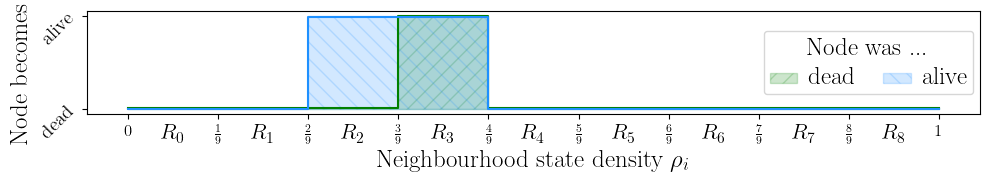

In [ ]:
SAVEFIG = False
savename = 'gol_as_llna-diagram.jpg'

resolution = 9

# GoL as LLNA model
beta = 8
sigma = 12
born_if = binary_indices(beta)
survive_if = binary_indices(sigma)
model = LLNA(resolution, x=born_if, y=survive_if, iso=True)

# plot both diagrams
fig, ax = plt.subplots(1,1,figsize=(10,1.9))
model.diagram(ax=ax)

# delete separate ax labels
size=18
ax.set_xlabel(fr'Neighbourhood state density $\rho_i$', fontsize=size)
ax.set_ylabel(fr'Node becomes', fontsize=size, y=0.4)
# ax.set_title(fr"Local update rule diagram for {model.__str__(latex=True)} (the Game of Life)", fontsize=size)
ax.set_title(None)

ax.set_xticks(np.linspace(0,1,2*resolution+1))
ax.set_xticklabels([f'$0$', f'$R_0$',
                    f'$\\frac{1}{9}$', f'$R_1$',
                    f'$\\frac{2}{9}$', f'$R_2$',
                    f'$\\frac{3}{9}$', f'$R_3$',
                    f'$\\frac{4}{9}$', f'$R_4$',
                    f'$\\frac{5}{9}$', f'$R_5$',
                    f'$\\frac{6}{9}$', f'$R_6$',
                    f'$\\frac{7}{9}$', f'$R_7$',
                    f'$\\frac{8}{9}$', f'$R_8$', f'$1$'])

ticks = ax.xaxis.get_major_ticks()
for i, tick in enumerate(ticks):
    if i % 2 == 1:
        tick.tick1line.set_markersize(0)

# ax.set_xticklabels(ax.get_xticklabels(), fontsize=size-4)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=size-4)

xticklabels = ax.get_xticklabels()
for i, label in enumerate(xticklabels):
    if i % 2 == 1:
        label.set_fontsize(size-2)
    else:
        label.set_fontsize(size-6)

legend = ax.legend(ncol=2, loc='center right')
legend.set_title("Node was ...", prop={'size': size})
for text in legend.get_texts():
    text.set_fontsize(size)  # Change legend font size

fig.tight_layout()

if SAVEFIG:
    plt.savefig(f'../figures/{savename}', bbox_inches='tight', dpi=1200)

### example of isomorphic rules

This is optional (I will probably delete this from the manuscript).

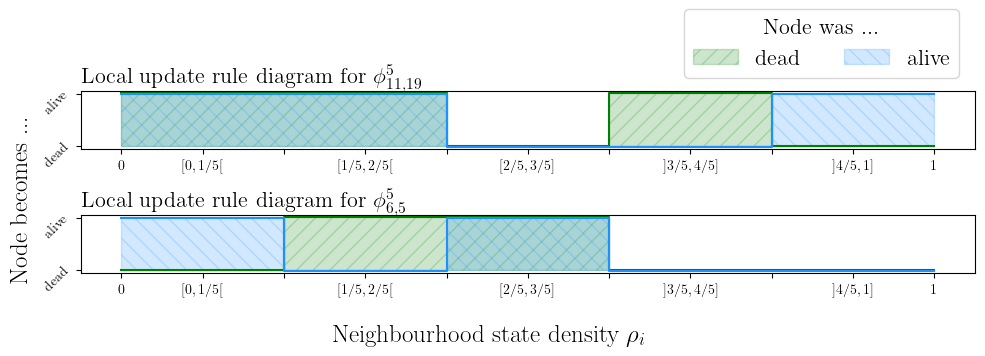

In [5]:
SAVEFIG = False
savename = 'compare-two-iso-rules.jpg'

# local update rule diagram
def binary_indices(n: int) -> list:
    """
    Returns a list of indices where bits are 1 in the binary representation of n.
    """
    return [i for i, bit in enumerate(bin(n)[:1:-1]) if bit == '1']

resolution = 5

# first model
beta = 11
sigma = 19
born_if = binary_indices(beta)
survive_if = binary_indices(sigma)
model = LLNA(resolution, x=born_if, y=survive_if, iso=True)

# second model
beta_iso = 2**resolution - 1 - np.sum([2**(resolution-1-i) for i in survive_if])
sigma_iso = 2**resolution - 1 - np.sum([2**(resolution-1-i) for i in born_if])
born_if_iso = binary_indices(beta_iso)
survive_if_iso = binary_indices(sigma_iso)
model_iso = LLNA(resolution, x=born_if_iso, y=survive_if_iso, iso=True)

# plot both diagrams
fig, axs = plt.subplots(2,1,figsize=(10,3))
model.diagram(ax=axs[0])
model_iso.diagram(ax=axs[1])

# delete separate ax labels
axs[0].set_ylabel(None)
axs[1].set_ylabel(None)
axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

# rewrite ax titles
size=16
axs[0].set_title(None)
axs[1].set_title(None)
axs[0].set_title(fr"Local update rule diagram for {model.__str__(latex=True)}", fontsize=size, loc='left')
axs[1].set_title(fr"Local update rule diagram for {model_iso.__str__(latex=True)}", fontsize=size, loc='left')

# Change some legend props after the legend is created
axs[0].legend().remove()
axs[1].legend().remove()
# legend = axs[1].legend(ncol=2, loc='center right')
# legend.set_title("Node was ...", prop={'size': size})
# for text in legend.get_texts():
#     text.set_fontsize(size)  # Change legend font size

size=18
# fig.suptitle("Local update rule diagrams", fontsize=size)
fig.supxlabel(fr'Neighbourhood state density $\rho_i$', fontsize=size)
fig.supylabel(fr'Node becomes ...', fontsize=size)

# Create a custom legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='upper right', bbox_to_anchor=(.98, 1.17), fontsize=size-2, title="Node was ...", title_fontsize=size-2)

fig.tight_layout()

if SAVEFIG:
    plt.savefig(f'../figures/{savename}', bbox_inches='tight', dpi=1200)

# Genotype parameters

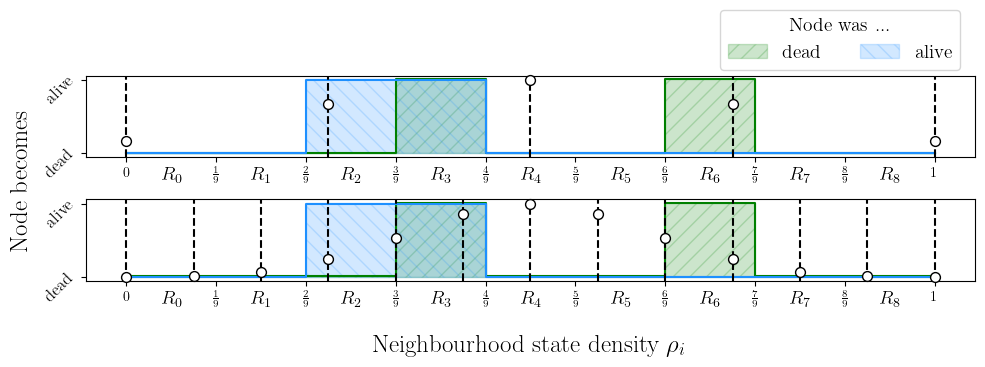

In [ ]:
SAVEFIG = False
savename_prefix = f'compare-two-degrees_diagram_'

resolution = 9
degree0 = 4
degree1 = 12

# model
beta = 72
sigma = 12
born_if = binary_indices(beta)
survive_if = binary_indices(sigma)
model = LLNA(resolution, x=born_if, y=survive_if, iso=True)
savename = savename_prefix + f'{model.__str__()}.jpg'

# plot both diagrams
fig, axs = plt.subplots(2,1,figsize=(10,3))
model.diagram(ax=axs[0], degree=degree0, plot_dist=True)
model.diagram(ax=axs[1], degree=degree1, plot_dist=True)

# delete separate ax labels
axs[0].set_ylabel(None)
axs[1].set_ylabel(None)
axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

# rewrite ax titles
size=16
axs[0].set_title(None)
axs[1].set_title(None)
# axs[0].set_title(fr"Local update rule diagram for {model.__str__(latex=True)} for degree {degree0}", fontsize=size)
# axs[1].set_title(fr"Local update rule diagram for {model.__str__(latex=True)} for degree {degree1}", fontsize=size)

# Change some legend props after the legend is created
axs[0].legend().remove()
axs[1].legend().remove()
# legend = axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(.9, 1.2))
# legend.set_title("Node was ...", prop={'size': size})
# for text in legend.get_texts():
    # text.set_fontsize(size)  # Change legend font size

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=size-4)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=size-4)
    ax.set_xticks(np.linspace(0,1,2*resolution+1))
    ax.set_xticklabels([f'$0$', f'$R_0$',
                        f'$\\frac{1}{9}$', f'$R_1$',
                        f'$\\frac{2}{9}$', f'$R_2$',
                        f'$\\frac{3}{9}$', f'$R_3$',
                        f'$\\frac{4}{9}$', f'$R_4$',
                        f'$\\frac{5}{9}$', f'$R_5$',
                        f'$\\frac{6}{9}$', f'$R_6$',
                        f'$\\frac{7}{9}$', f'$R_7$',
                        f'$\\frac{8}{9}$', f'$R_8$', f'$1$'])
    ticks = ax.xaxis.get_major_ticks()
    for i, tick in enumerate(ticks):
        if i % 2 == 1:
            tick.tick1line.set_markersize(0)
    xticklabels = ax.get_xticklabels()
    for i, label in enumerate(xticklabels):
        if i % 2 == 1:
            label.set_fontsize(size-2)
        else:
            label.set_fontsize(size-6)
    

# Create a custom legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='upper right', bbox_to_anchor=(.98, 1.2), fontsize=size-2, title="Node was ...", title_fontsize=size-2)

size=18
# fig.suptitle(fr"Local update rule diagram for {model.__str__(latex=True)} for degrees {degree0} and {degree1}", fontsize=size)
fig.supxlabel(fr'Neighbourhood state density $\rho_i$', fontsize=size, x=0.54)
fig.supylabel(fr'Node becomes', fontsize=size, y=0.6)

fig.tight_layout()

if SAVEFIG:
    plt.savefig(f'../figures/{savename}', bbox_inches='tight', dpi=1200)

### Mean-field curve and Derrida curve

100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


[0.25       0.36791992]
[2.5        4.10351563]


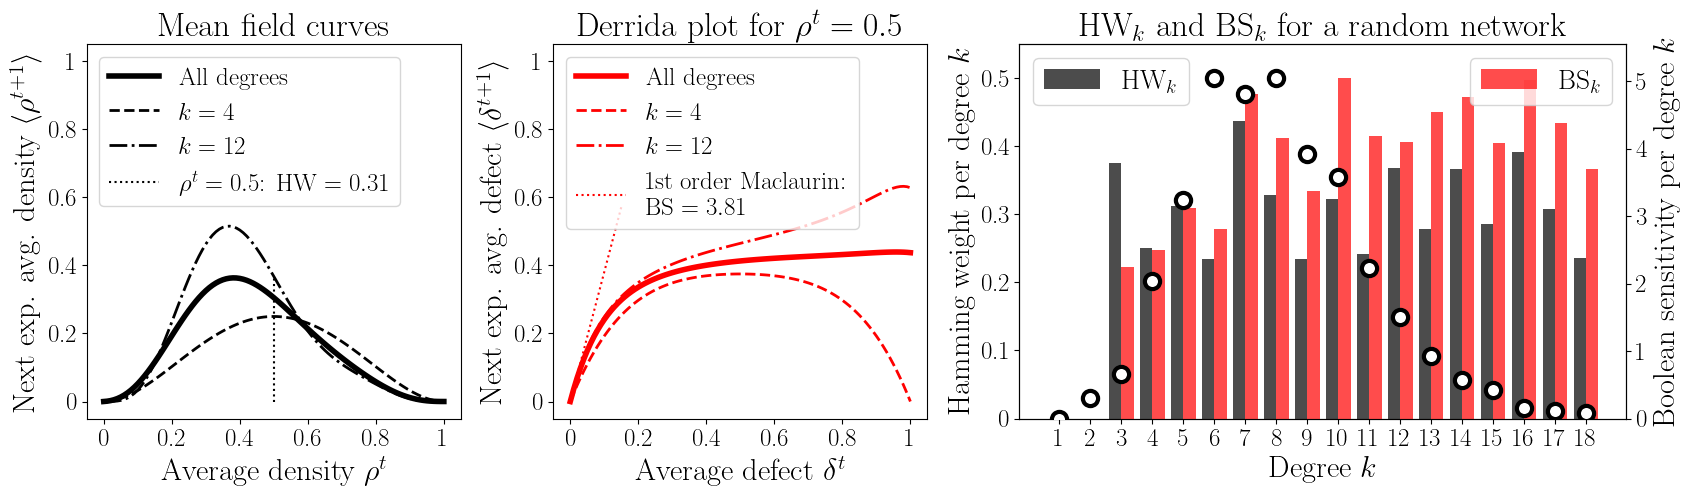

In [8]:
SAVEFIG = False

# create the model
life_like_dict = return_life_like_dict()
life_like_name = "highlife" # i like: replicator, diamoeba, 34_life, 2x2 (looks like a python that swallowed an elephant)
beta, sigma = life_like_dict[life_like_name]
B_set = binary_indices(beta)
S_set = binary_indices(sigma)

# create the graph
CREATE_NEW_GRAPH = True

if CREATE_NEW_GRAPH:
    num_nodes = 900
    avg_degree = 8
    num_edges = num_nodes * avg_degree // 2  # since undirected graph, each edge is counted twice
    # Generate a connected random graph using the Erdos-Renyi model
    random_graph = ig.Graph.Erdos_Renyi(n=num_nodes, m=num_edges)
    while not random_graph.is_connected():
        random_graph = ig.Graph.Erdos_Renyi(n=num_nodes, m=num_edges)
    degree_per_node = random_graph.degree()
    degree_counts = np.bincount(degree_per_node)[1:] # skip first, because by design there is no degree=0
    degree_distribution = degree_counts / np.sum(degree_counts)
    degrees = np.arange(1, max(degree_per_node)+1)

# this is some kind of Fourier transformation! Showing the elements that make up the total wave
resolution = 9
model = LLNA(resolution, B_set, S_set, iso=True)
B_set, S_set = model.rule
degrees_to_plot = np.array([4, 12])
ls_list = ['--', '-.']
default_colors = np.array((plt.rcParams['axes.prop_cycle'].by_key()['color']))
color_list = ['k', 'k'] #  default_colors[1:3]

# mean field curve and HW values
num_dens_points = 101
current_dens = np.linspace(0,1,num_dens_points)
next_dens_list = []
HW_list = []
for degree in tqdm(degrees, total=len(degrees)):
    # mean field curve
    next_dens = mean_field_dens_propagation(resolution, B_set, S_set, current_dens, degree)
    next_dens_list.append(next_dens)
    # Hamming weight
    HW = hamming_weight(resolution, B_set, S_set, degree)
    HW_list.append(HW)
next_dens_array = np.array(next_dens_list)
# take weighted average
next_dens_average = np.sum(degree_counts[:,np.newaxis]/num_nodes*next_dens_array, axis=0)
HW_array = np.array(HW_list)
HW_average = np.sum(np.array(degree_distribution) * np.array(HW_array))

# Derrida plot and BS value
init_config_dens = 0.5
num_delta_points = 101
current_deltas = np.linspace(0, 1, num_delta_points)
next_deltas_list = []
BS_list = []
for degree in tqdm(degrees, total=len(degrees)):
    # Derrida plot
    next_deltas = derrida_map_analytical(resolution, B_set, S_set, current_deltas, degree, init_config_dens=init_config_dens)
    next_deltas_list.append(next_deltas)
    # Boolean sensitivity
    BS = boolean_sens(resolution, B_set, S_set, degree, norm_degree=False)
    BS_list.append(BS)
next_deltas_array = np.array(next_deltas_list)
# take weighted average
next_deltas_average = np.sum(degree_counts[:,np.newaxis]/num_nodes*next_deltas_array, axis=0)
BS_array = np.array(BS_list)
BS_average = np.sum(np.array(degree_distribution) * np.array(BS_array))

# add for completeness
LHS = int(0 in B_set)
RHS = int(resolution-1 in S_set)


# create figure
fig, axs = plt.subplots(1,3,figsize=(17,5), width_ratios=[1,1,1.618])

next_dens_array_to_plot = next_dens_array[degrees_to_plot-1]
HW_array_to_plot = HW_array[degrees_to_plot-1]
# plot average
axs[0].plot(current_dens, next_dens_average, label=f'All degrees', ls='-', color='black', lw=4)
for next_dens, degree, HW, ls, color in zip(next_dens_array_to_plot, degrees_to_plot, HW_array_to_plot, ls_list, color_list):
    # label=f'Degree {degree}, $\\text{{HW}}_{{{degree}}} = {round(HW,2)}$'
    label = f'$k={degree}$'
    axs[0].plot(current_dens, next_dens, label=label, ls=ls, color=color, lw=2)
    # plt.scatter(0.5, HW, color='black', s=100, marker='*')
# ax.plot(current_dens, next_dens_average, color='black', label="Average", lw=4, ls='-.')
# plt.plot([0,1], [0,1], 'k--')
# ax.plot([0, .5], [HW_average, HW_average], 'k--', label="Average Hamming weight")
# ax.scatter(0, LHS, color='black', s=100, marker='x')
# ax.scatter(1, RHS, color='black', s=100, marker='x')
# plot indicator for HW
axs[0].plot([.5,.5], [0,np.max(HW_array_to_plot)], 'k:', label=f"$\\rho^t=0.5$: $\\text{{HW}} = {round(HW_average,2)}$")
# axs[0].plot([0, .5], [HW_average, HW_average], 'k:')

fontsize=22

# plot mean field curves
axs[0].legend(fontsize=fontsize-4, loc='upper left')
axs[0].set_xlabel("Average density $\\rho^t$", fontsize=fontsize)
axs[0].set_ylabel("Next exp. avg. density $\\langle\\rho^{t+1}\\rangle$", fontsize=fontsize)
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])
ticklabels = [0, .2, .4, .6, .8, 1]
axs[0].set_xticks(ticklabels)
axs[0].set_yticks(ticklabels)
axs[0].set_xticklabels(ticklabels, size=fontsize-4)
axs[0].set_yticklabels(ticklabels, size=fontsize-4)
axs[0].set_title(f"Mean field curves", size=fontsize+2)
axs[0].set_aspect(1)

color_list = ['r', 'r']

next_deltas_array_to_plot = next_deltas_array[degrees_to_plot-1]
BS_array_to_plot = BS_array[degrees_to_plot-1]
# plot average
axs[1].plot(current_deltas, next_deltas_average, label=f'All degrees', ls='-', color='red', lw=4)
for next_deltas, degree, BS, ls, color in zip(next_deltas_array_to_plot, degrees_to_plot, BS_array_to_plot, ls_list, color_list):
    label = f'$k={degree}$'
    # label = f'Degree {degree}, $\\text{{BS}}_{{{degree}}} = {round(BS,2)}$'
    axs[1].plot(current_deltas, next_deltas, label=label, ls=ls, color=color, lw=2)
# add BS as slope
DC_factor = 0.15
axs[1].plot(np.array([0, 1])*DC_factor, np.array([0, BS_average])*DC_factor, 'r:', label=f'1st order Maclaurin:\n$\\text{{BS}} = {round(BS_average,2)}$')

# plot Derrida plot
axs[1].legend(fontsize=fontsize-4, loc='upper left')
axs[1].set_xlabel("Average defect $\\delta^t$", fontsize=fontsize)
axs[1].set_ylabel("Next exp. avg. defect $\\langle\\delta^{t+1}\\rangle$", fontsize=fontsize)
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
ticklabels = [0, .2, .4, .6, .8, 1]
axs[1].set_xticks(ticklabels)
axs[1].set_yticks(ticklabels)
axs[1].set_xticklabels(ticklabels, size=fontsize-4)
axs[1].set_yticklabels(ticklabels, size=fontsize-4)
axs[1].set_title(f"Derrida plot for $\\rho^t={round(init_config_dens,2)}$", size=fontsize+2)
axs[1].set_aspect(1)

# calculate the hamming weights for all degree
HW_list = [hamming_weight(resolution, B_set, S_set, d, norm=True) for d in degrees]
width = 0.4
axs[2].bar(degrees-width/2, HW_list, alpha=0.7, width=width, label="$\\text{{HW}}_k$", color='k', zorder=0)

# plot documentation
axs[2].set_xticks(degrees)
axs[2].set_xticklabels(degrees)
# axs[1].set_title(f"$\\text{{HW}}_k$ and $P(k)$ for a random network ($N={num_nodes}$, $\\langle k\\rangle = {avg_degree}$)", fontsize=fontsize+2)
axs[2].set_title(f"$\\text{{HW}}_k$ and $\\text{{BS}}_k$ for a random network", fontsize=fontsize+2)
axs[2].legend(loc='upper left', fontsize=fontsize-2)
axs[2].set_ylabel("Hamming weight per degree $k$", fontsize=fontsize)
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
axs[2].set_ylim([0, yticks[-1]*1.1])
axs[2].set_yticks(yticks)
axs[2].set_yticklabels(yticks, fontsize=fontsize-4)
axs[2].set_xlabel("Degree $k$", fontsize=fontsize)
axs[2].set_xticks(degrees)
axs[2].set_xticklabels(degrees, fontsize=fontsize-4)

ax_rhs = axs[2].twinx()
ax_rhs.bar(degrees+width/2, BS_array, alpha=0.7, width=width, label="$\\text{{BS}}_k$", color='r')
ax_rhs.legend(fontsize=fontsize-2, loc='upper right')
ax_rhs.set_ylabel(f"Boolean sensitivity per degree $k$", fontsize=fontsize)
ax_rhs.set_ylim([0, max(BS_array)*1.1])
yticks = [0, 1, 2, 3, 4, 5]
ax_rhs.set_yticks(yticks)
ax_rhs.set_yticklabels(yticks, fontsize=fontsize-4)

# fig.suptitle(f"Mean field curve and Hamming weights for rule {model.__str__(latex=True)}", fontsize=fontsize+4)

# Hamming weights on a random graph
# find degree distribution
scale_factor = 1 / np.max(degree_distribution) * np.max(BS_list)  # scale factor to fit the HW values into the plot
ax_rhs.scatter(degrees, degree_distribution*scale_factor, color='white', edgecolors='k', s=120, marker='o', zorder=10, linewidths=3)

fig.tight_layout()

savename = f"mean_field_curve-derrida_curve-HW_BS_distribution-{model.__str__()}.pdf"
if SAVEFIG:
    plt.savefig(f'../figures/{savename}', bbox_inches='tight')

print(HW_array_to_plot)
print(BS_array_to_plot)

### Derrida curves for various original densities

100%|██████████| 10/10 [02:08<00:00, 12.84s/it]


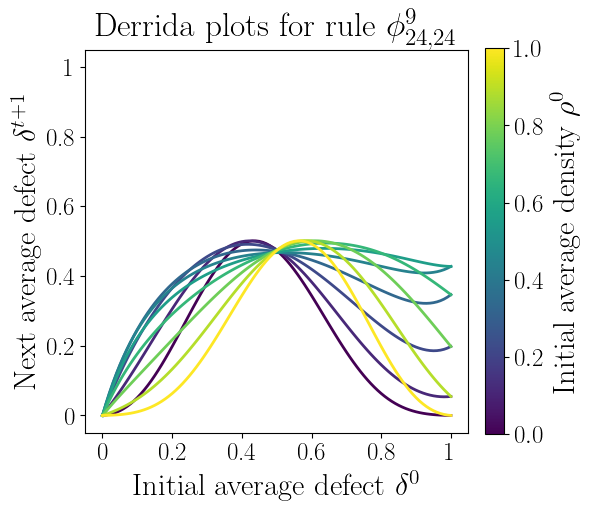

In [10]:
### NOTE: this can take a while

SAVEFIG = True

# create the model
life_like_dict = return_life_like_dict()
life_like_name = "34_life" # i like: replicator, diamoeba, 34_life, 2x2
beta, sigma = life_like_dict[life_like_name]
B_set = binary_indices(beta)
S_set = binary_indices(sigma)

NEW_GRAPH = False

if NEW_GRAPH:
    # create the graph
    num_nodes = 1000
    avg_degree = 8
    # Probability for edge creation
    p = avg_degree / (num_nodes - 1)
    # Generate a connected random graph using the Erdos-Renyi model
    random_graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=p)
    while not random_graph.is_connected():
        random_graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=p)
    degree_per_node = random_graph.degree()
    degree_counts = np.bincount(degree_per_node)[1:] # skip first, because by design there is no degree=0
    degree_distribution = degree_counts / np.sum(degree_counts)
    degrees = np.arange(1, max(degree_per_node)+1)

# this is some kind of Fourier transformation!
resolution = 9
model = LLNA(resolution, B_set, S_set, iso=True)

# Derrida plot
init_config_dens_res = 10
init_config_dens_array = np.linspace(0, 1, init_config_dens_res)
num_delta_points = 101
current_deltas = np.linspace(0, 1, num_delta_points)
next_deltas_avg_per_init_config = []
for init_config_dens in tqdm(init_config_dens_array, total=init_config_dens_res):
    next_deltas_list = []
    for degree in degrees:
        # Derrida plot
        next_deltas = derrida_map_analytical(resolution, B_set, S_set, current_deltas, degree, init_config_dens=init_config_dens)
        next_deltas_list.append(next_deltas)
    next_deltas_array = np.array(next_deltas_list)
    # take weighted average
    next_deltas_average = np.sum(degree_counts[:,np.newaxis]/num_nodes*next_deltas_array, axis=0)
    next_deltas_avg_per_init_config.append(next_deltas_average)
next_deltas_avg_per_init_config = np.array(next_deltas_avg_per_init_config)

# create figure
fig, ax = plt.subplots(1,1,figsize=(6,6))
fontsize=22

norm = plt.Normalize(init_config_dens_array.min(), init_config_dens_array.max())

# plot average
for init_config_dens, next_delta_avg_per_init_config in zip(init_config_dens_array, next_deltas_avg_per_init_config):
    color = plt.cm.viridis(norm(init_config_dens))
    ax.plot(current_deltas, next_delta_avg_per_init_config, label=f'$\\rho^0 = {round(init_config_dens,2)}$', lw=2, alpha=1, color=color)

# add colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=fontsize-4)
cbar.set_label('Initial average density $\\rho^0$', fontsize=fontsize)

# plot Derrida plot
# ax.legend(fontsize=fontsize-4, loc='upper center', ncol=2)
ax.set_xlabel("Initial average defect $\\delta^0$", fontsize=fontsize)
ax.set_ylabel("Next average defect $\\delta^{t+1}$", fontsize=fontsize)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ticklabels = [0, .2, .4, .6, .8, 1]
ax.set_xticks(ticklabels)
ax.set_yticks(ticklabels)
ax.set_xticklabels(ticklabels, size=fontsize-4)
ax.set_yticklabels(ticklabels, size=fontsize-4)
ax.set_title(f"Derrida plots for rule {model.__str__(latex=True)}", size=fontsize+2)
ax.set_aspect(1)

fig.tight_layout()

### Correlation Hamming weight and Boolean sensitivity

In [11]:
# let's compare the sensitivity with the Hamming weight for all NAs

resolution = 5
degree_rules = 3

sigmas=range(2**resolution)
betas=range(2**resolution)

HWs_rules = []
BSs_rules = []
equiv_rule_list = []
for beta in tqdm(betas, total=len(betas)):
    born_if = binary_indices(beta)
    for sigma in sigmas:
        if (beta, sigma) not in equiv_rule_list:
            survive_if = binary_indices(sigma)
            HW = hamming_weight(resolution, born_if, survive_if, degree_rules, norm=True, iso=True)
            BS = boolean_sens(resolution, born_if, survive_if, degree_rules, norm_degree=False, iso=True)
            HWs_rules.append(HW)
            BSs_rules.append(BS)
            # add the equivalent rule to the list
            beta_equiv, sigma_equiv = return_equivalent_rule(resolution, born_if, survive_if, return_decimals=True)
            equiv_rule_list.append((beta_equiv, sigma_equiv))

100%|██████████| 32/32 [00:00<00:00, 44.58it/s]


In [12]:
# let's compare the sensitivity with the Hamming weight for all non-equivalent NAs
resolution = 5

beta=6
sigma=11
max_degree = 250

born_if = binary_indices(beta)
survive_if = binary_indices(sigma)
model_degrees = LLNA(resolution, x=born_if, y=survive_if, iso=True)

HWs_degrees = []
BSs_degrees = []
for degree in range(1,max_degree+1):
    HW = hamming_weight(resolution, born_if, survive_if, degree, norm=True, iso=True)
    BS = boolean_sens(resolution, born_if, survive_if, degree, norm_degree=False, iso=True)
    HWs_degrees.append(HW)
    BSs_degrees.append(BS)

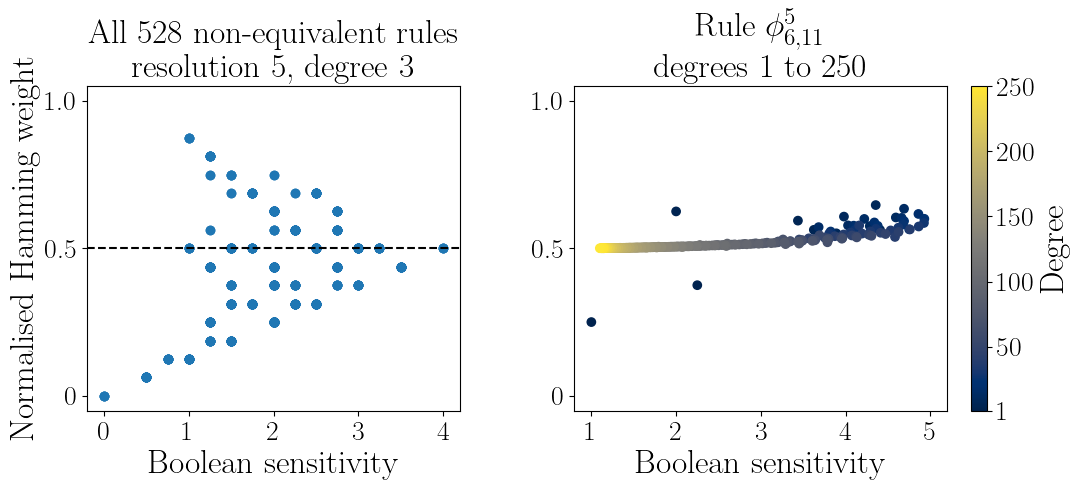

In [13]:
SAVEFIG = True
savename=f'correlation-HW-BS_{model_degrees.__str__()}.pdf'

fig, axs = plt.subplots(1,3,figsize=(11,5), width_ratios=[1,0.001,1.25])
fontsize=24

axs[0].scatter(BSs_rules, HWs_rules)
axs[0].set_title(f"All 528 non-equivalent rules\nresolution {resolution}, degree {degree_rules}", fontsize=fontsize)
axs[0].axhline(.5, color='black', linestyle='--')
xticks = [0, 1, 2, 3, 4]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-4)
axs[0].set_xlim([-0.2, 4.2])

axs[1].axis('off')

sc = axs[2].scatter(BSs_degrees, HWs_degrees, c=range(1, max_degree+1), cmap='cividis')
axs[2].set_title(f"Rule {model_degrees.__str__(latex=True)}\ndegrees $1$ to ${max_degree}$", fontsize=fontsize)
xticks = [1, 2, 3, 4, 5]
axs[2].set_xticks(xticks)
axs[2].set_xticklabels(xticks, fontsize=fontsize-4)
axs[2].set_xlim([0.8, 5.2])

# Add colorbar linked to the scatter plot
cbar = fig.colorbar(sc, ax=axs[2], ticks=[1, 50, 100, 150, 200, 250])
cbar.set_label("Degree", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize-4)

for ax in axs:
    ax.set_xlabel("Boolean sensitivity", fontsize=fontsize)
    if ax == axs[0]:
        ax.set_ylabel("Normalised Hamming weight", fontsize=fontsize)
    # ax.set_xlim([-0.05,1.05])
    yticks = [0, 0.5, 1.]
    # ax.set_xticks(xticks)
    # ax.set_xticklabels(xticks, fontsize=fontsize-4)
    ax.set_ylim([-0.05, 1.05])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize-4)
    # ax.set_aspect(1.0)

# plt.subplots_adjust(wspace=0.1)
fig.tight_layout()

if SAVEFIG:
    plt.savefig(f'../figures/{savename}', bbox_inches='tight')


# Phenotype parameters

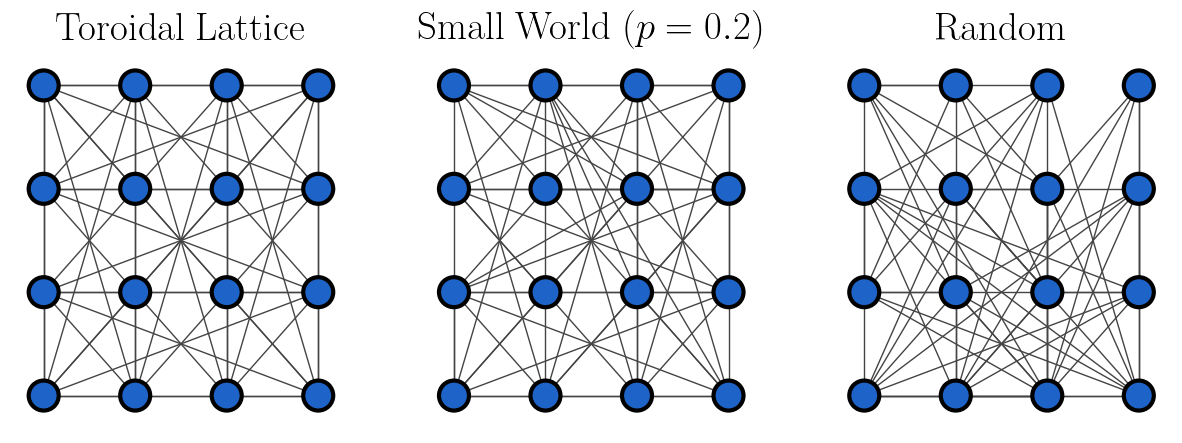

In [14]:
SAVEFIG = True
savename = "three-networks.pdf"

# Parameters
L = 4                   # Grid size (L x L) WATCH OUT with values, becomes intensive fast
rewiring_prob = 0.2     # Rewiring probability

# Create toroidal lattice and rewire
lattice_graph = create_2d_torus_lattice(L, degree=8)
small_world_graph = watts_strogatz_rewire(lattice_graph, rewiring_prob)
random_graph = watts_strogatz_rewire(lattice_graph, 1.)

# save graphs and edges in list
graphs = [lattice_graph, small_world_graph, random_graph]
graph_names = ["Toroidal Lattice", f"Small World ($p={round(rewiring_prob,2)}$)", "Random"]
graph_vertex_shape = ["circle", "circle", "circle"] # ["circle", "square", "triangle"]

# Optional: Visualize
fig, axs = plt.subplots(1,3,figsize=(15,5))
layout = lattice_graph.layout("grid")  # Grid layout
vertex_size  = 30
edge_width = 1
vertex_frame_width = 3
fontsize = 28

ugent_colors = get_ugent_colors_dict()
colors = [ugent_colors['ugent_blue']]*3

for ax, graph, name, vertex_shape, vertex_color in zip(axs[:3], graphs, graph_names, graph_vertex_shape, colors):
    ig.plot(graph, layout=layout, vertex_size=vertex_size, edge_width=edge_width, target=ax, vertex_color=vertex_color, vertex_shape=vertex_shape, vertex_frame_width=vertex_frame_width)
    ax.set_title(name, fontsize=fontsize)

# fig.tight_layout()

if SAVEFIG:
    plt.savefig(f"../figures/{savename}", bbox_inches='tight')

In [15]:
print(f"Number of undirected edges in lattice_graph: {lattice_graph.ecount()}")

Number of undirected edges in lattice_graph: 64


### State average evolution

**The example time series**

In [20]:
# make real-sized networks NOTE takes a while

# Parameters
L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
rewiring_prob = 0.2     # Rewiring probability
num_graphs = 30

# Create toroidal lattice and rewire
lattice_graphs = [create_2d_torus_lattice(L, degree=8)]*num_graphs
small_world_graphs = [watts_strogatz_rewire(lattice_graphs[0], rewiring_prob) for _ in range(num_graphs)]
random_graphs = [watts_strogatz_rewire(lattice_graphs[0], 1.) for _ in range(num_graphs)]

# find edges for lattice graph
lattice_graph = lattice_graphs[0]
lattice_graph.to_directed()
lattice_edges = [tc.tensor(lattice_graph.get_edgelist()).T]*num_graphs
lattice_graph.to_undirected()

# find edges for small world graph
small_world_edges = []
for small_world_graph in small_world_graphs:
    small_world_graph.to_directed()
    small_world_edges.append(tc.tensor(small_world_graph.get_edgelist()).T)
    small_world_graph.to_undirected()

# find edges for random graph
random_edges = []
for random_graph in random_graphs:
    random_graph.to_directed()
    random_edges.append(tc.tensor(random_graph.get_edgelist()).T)
    random_graph.to_undirected()

edges_list = [lattice_edges, small_world_edges, random_edges]
graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

In [21]:
RUN_AGAIN = False

if RUN_AGAIN:

    # choose LLCA that will be topologically generalised
    life_like_dict = return_life_like_dict()
    like_like_rule = "morley"

    resolution = 9
    beta, sigma = life_like_dict[like_like_rule]
    B_set = binary_indices(beta)
    S_set = binary_indices(sigma)
    model = LLNA(resolution, B_set, S_set, iso=True)

    num_nodes = L**2
    T = 100 # num_nodes // 10

    def init_config_with_dens(N, dens):
        # defines a random initial configuration with a fixed state density
        s0 = np.zeros(N, dtype=int)
        s0[:np.round(dens*N).astype(int)] = 1.
        np.random.shuffle(s0)
        return s0

    num_config = 30
    init_dens_list = [0.25, 0.5, 0.75]
    init_dens_str_list = [f'1/4', f'2/4', f'3/4']
    init_dens_colors = ['olive', 'maroon', 'dodgerblue']
    ls_list = ['-', '--', '-.']

    metadata = {
        "resolution": resolution,
        "beta": beta,
        "sigma": sigma,
        "num_nodes": num_nodes,
        "num_config": num_config,
        "num_graphs": num_graphs,
        "T": T
    }

    # Create file in "append" mode (if it exists, it will be opened; if not, it will be created)
    with h5py.File('data/state_density_time_series.h5', 'a') as f:
        # Create nested groups using metadata   
        group_path = f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
        group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"

        # iterate over graph types
        for edges, graph_name in zip(edges_list, graph_names):
            print(f"Processing graph type: {graph_name}")
            # iterate over three distinct initial densities
            for init_dens, init_dens_str, color, ls in tqdm(zip(init_dens_list, init_dens_str_list, init_dens_colors, ls_list), total=len(init_dens_list)):
                # make empty array for state averages
                state_averages = np.empty((T+1,0))
                # iterate over particular graphs within each type
                for edge in edges:
                    # for each graph, make some random initial configurations with the given density
                    init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                    # run simulation over a number of time steps
                    configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                    # calculate the means over all nodes
                    current_state_averages = np.mean(configs, axis=2).T
                    # vertically stack the means for all graphs
                    state_averages = np.hstack((state_averages, current_state_averages))
                # calcule the quartiles for each time step as time series
                q1_of_means = np.quantile(state_averages, 0.25, axis=1)
                q2_of_means = np.quantile(state_averages, 0.50, axis=1)
                q3_of_means = np.quantile(state_averages, 0.75, axis=1)

                # Save array inside the group
                group_path_current = group_path + f"/{graph_name.replace(' ', '_')}/init_dens_{init_dens_str.replace('/', 'f')}"
                group = f.create_group(group_path_current)

                group.create_dataset('q1_of_means', data=q1_of_means)
                group.create_dataset('q2_of_means', data=q2_of_means)
                group.create_dataset('q3_of_means', data=q3_of_means)


C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\1383806324.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


r9beta328sigma52/ (Group)
  r9beta328sigma52/N900T100M30num_graphs30/ (Group)
    r9beta328sigma52/N900T100M30num_graphs30/Lattice/ (Group)
      r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_1f4/ (Group)
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_1f4/q1_of_means (Dataset) shape=(101,), dtype=float64
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_1f4/q2_of_means (Dataset) shape=(101,), dtype=float64
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_1f4/q3_of_means (Dataset) shape=(101,), dtype=float64
      r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_2f4/ (Group)
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_2f4/q1_of_means (Dataset) shape=(101,), dtype=float64
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_2f4/q2_of_means (Dataset) shape=(101,), dtype=float64
        r9beta328sigma52/N900T100M30num_graphs30/Lattice/init_dens_2f4/q3_of_means (Dataset) shape=

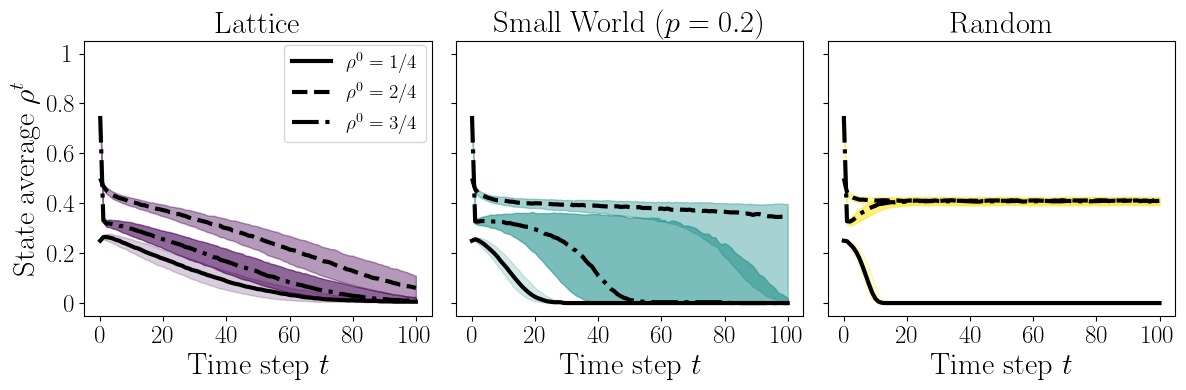

In [23]:
SAVEFIG = True
savename_prefix = "state-average-evolution_three-networks_"

metadata = {
    "resolution": 9,
    "beta": 328,
    "sigma": 52,
    "num_nodes": 900,
    "num_config": 30,
    "num_graphs": 30,
    "T": 100
}

init_dens_str_list = [f'1/4', f'2/4', f'3/4']
model = LLNA(metadata['resolution'], binary_indices(metadata['beta']), binary_indices(metadata['sigma']), iso=True)

fig, axs = plt.subplots(1, len(graph_names), figsize=(4*len(graph_names), 4), sharey=True)
fontsize=22
alpha_factor = 0.05

# Get a colormap with green shades
from matplotlib.cm import get_cmap
# cmaps = [get_cmap("Greens"), get_cmap("Blues"), get_cmap("Oranges")]
# colors = [[cmap(i) for i in [0.4, 0.6, 0.9]] for cmap in cmaps]
cmap = get_cmap("viridis")
colors = [cmap(0.0), cmap(0.5), cmap(1.0)]  # Use specific colors from the colormap
alphas = [0.2, 0.4, 0.6]
ls_list = ['-', '--', '-.']

### look at tree structure
def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/ (Group)")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

with h5py.File('../data/state_density_time_series.h5', 'r') as f:
    f.visititems(print_h5_tree)

# Open the file in read mode
with h5py.File('../data/state_density_time_series.h5', 'r') as f:
    ### load data for various initial state densities
    # Navigate to the correct group path
    group_path = (
        f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
        f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
    )
    
    for ax, graph_name, color in zip(axs, graph_names, colors):
        for init_dens_str, alpha, ls in zip(init_dens_str_list, alphas, ls_list):

            group_path_current = group_path + f"/{graph_name.replace(' ', '_')}/init_dens_{init_dens_str.replace('/', 'f')}"

            # Access the group
            group_current = f[group_path_current]
            # Load datasets
            q1_of_means = group_current['q1_of_means'][:]
            q2_of_means = group_current['q2_of_means'][:]
            q3_of_means = group_current['q3_of_means'][:]

            # ax.plot(means_over_nodes, alpha=alpha_factor*100/num_config, color=color)
            ax.plot(q2_of_means, lw=3, color='k', ls=ls, label=f"$\\rho^0 = {init_dens_str}$")
            ax.fill_between(range(metadata["T"]+1), q1_of_means, q3_of_means, lw=1, color=color, alpha=alpha)
            ax.set_title(f"{graph_name}", fontsize=fontsize)
            ax.set_xlabel("Time step $t$", fontsize=fontsize)
            ax.set_ylim([-0.05, 1.05])
            yticks = [0, .2, .4, .6, .8, 1]
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize-4)
            xticks = [0, 20, 40, 60, 80, 100]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, fontsize=fontsize-4)
            axs[0].set_ylabel("State average $\\rho^t$", fontsize=fontsize)

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
# Create black handles (same style, but black color)
from matplotlib.lines import Line2D
black_handles = [
    Line2D([0], [0],
           color='black', 
           linestyle=h.get_linestyle(), 
           marker=h.get_marker(), 
           linewidth=h.get_linewidth(),
           markersize=h.get_markersize())
    for h in handles
]
fig.legend(black_handles, labels, loc='upper right', ncol=1, fontsize=fontsize-8, bbox_to_anchor=(.367, 0.90) )

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}", fontsize=fontsize+2, x=0.3, y=.985)
fig.tight_layout()

savename = savename_prefix + model.__str__() + ".pdf"

if SAVEFIG:
    plt.savefig(f"../figures/{savename}", bbox_inches='tight')

**Convergence value of $\bar{\rho}^T$**

In [25]:
from analysis import median_and_percentiles_over_ensemble
import h5py

Calculate final density in function of initial density for three networks

In [ ]:
RUN_AGAIN = False
SAVEDATA = False
# takes a long time!

if RUN_AGAIN:

    T = 100

    resolution = 9
    beta, sigma = life_like_dict["morley"]
    B_set = binary_indices(beta)
    S_set = binary_indices(sigma)
    model = LLNA(resolution, B_set, S_set, iso=True)

    def init_config_with_dens(N, dens):
        # defines a random initial configuration with a fixed state density
        s0 = np.zeros(N, dtype=int)
        s0[:np.round(dens*N).astype(int)] = 1.
        np.random.shuffle(s0)
        return s0

    # Parameters
    L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
    num_nodes = L**2
    rewiring_prob = 0.2     # Rewiring probability
    num_graphs = 30

    # TODO: average over a number of graphs (not only over initial configurations)

    # Create toroidal lattice and rewire
    lattice_graphs = [create_2d_torus_lattice(L, degree=8)]*num_graphs
    small_world_graphs = [watts_strogatz_rewire(lattice_graphs[0], rewiring_prob) for _ in range(num_graphs)]
    random_graphs = [watts_strogatz_rewire(lattice_graphs[0], 1.) for _ in range(num_graphs)]

    # find edges for lattice graph
    lattice_graph = lattice_graphs[0]
    lattice_graph.to_directed()
    lattice_edges = [tc.tensor(lattice_graph.get_edgelist()).T]*num_graphs
    lattice_graph.to_undirected()

    # find edges for small world graph
    small_world_edges = []
    for small_world_graph in small_world_graphs:
        small_world_graph.to_directed()
        small_world_edges.append(tc.tensor(small_world_graph.get_edgelist()).T)
        small_world_graph.to_undirected()

    # find edges for random graph
    random_edges = []
    for random_graph in random_graphs:
        random_graph.to_directed()
        random_edges.append(tc.tensor(random_graph.get_edgelist()).T)
        random_graph.to_undirected()

    edges_list = [lattice_edges, small_world_edges, random_edges]

    num_config = 30
    init_dens_res = 51
    init_dens_array = np.linspace(0,1,init_dens_res)
    delta_t = 10

    dens_list_per_init_dens_per_graph = []
    median_list_per_graph = []
    lw_perc_list_per_graph = []
    up_perc_list_per_graph = []
    for i, edges in enumerate(edges_list):
        print(f"Working on graph type {i+1}.")
        dens_list_per_init_dens = []
        median_list = []
        lw_perc_list = []
        up_perc_list = []
        for init_dens in tqdm(init_dens_array, total=len(init_dens_array)):
            configs_array = np.empty((0, T+1, num_nodes), dtype=int)
            for edge in edges:
                init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                # run simulation over a number of time steps
                configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                configs_array = np.vstack((configs_array, configs))
            # calculate the means over all nodes
            means_over_nodes = np.mean(configs_array, axis=2).T
            dens_list_per_init_dens.append(means_over_nodes)
            # calcule the median and quantiles
            median, lw_perc, up_perc = median_and_percentiles_over_ensemble(means_over_nodes, delta_t)
            median_list.append(median)
            lw_perc_list.append(lw_perc)
            up_perc_list.append(up_perc)
        dens_list_per_init_dens_per_graph.append(dens_list_per_init_dens)
        median_list_per_graph.append(median_list)
        lw_perc_list_per_graph.append(lw_perc_list)
        up_perc_list_per_graph.append(up_perc_list)
    dens_list_per_init_dens_per_graph = np.array(dens_list_per_init_dens_per_graph)
    median_list_per_graph = np.array(median_list_per_graph)
    lw_perc_list_per_graph = np.array(lw_perc_list_per_graph)
    up_perc_list_per_graph = np.array(up_perc_list_per_graph)

    if SAVEDATA:
        metadata = {
            "num_nodes": num_nodes,
            "num_config": num_config,
            "T": T,
            "resolution": resolution,
            "beta": beta,
            "sigma": sigma,
            "init_dens_res": init_dens_res,
            "rewiring_prob": rewiring_prob,
            "num_graphs": num_graphs
            }
        # Create file in "append" mode
        with h5py.File('../data/final_state_densities.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"various_init_state_dens"     
            group_path = group_path + f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
            group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('init_dens_array', data=init_dens_array)
            group.create_dataset('dens_list_per_init_dens_per_graph', data=dens_list_per_init_dens_per_graph)
            group.create_dataset('median_list_per_graph', data=median_list_per_graph)
            group.create_dataset('lw_perc_list_per_graph', data=lw_perc_list_per_graph)
            group.create_dataset('up_perc_list_per_graph', data=up_perc_list_per_graph)

Calculate final value in function of rewiring probability of Watts-Strogatz network for three initial conditions

In [ ]:
RUN_AGAIN = False
SAVEDATA = False
# takes a long time

if RUN_AGAIN:

    # Parameters
    L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
    num_nodes = L**2
    num_graphs = 30
    rewiring_res = 51
    rewiring_prob_array = np.logspace(-2,0,rewiring_res) # logarithmically distributed between 0.01 and 1

    # Create toroidal lattice and rewire
    lattice_graph = create_2d_torus_lattice(L, degree=8)
    print(f"Creating {num_graphs} graphs of {num_nodes} nodes for each rewiring probability.")
    graphs = [[watts_strogatz_rewire(lattice_graph, rewiring_prob) for _ in range(num_graphs)] for rewiring_prob in tqdm(rewiring_prob_array, total=rewiring_res)]
    edges = []
    for i, rewiring_prob in enumerate(rewiring_prob_array):
        edges_per_rewiring_prob = []
        for graph in graphs[i]:
            # find edges
            graph.to_directed()
            edge = tc.tensor(graph.get_edgelist()).T
            edges_per_rewiring_prob.append(edge)
            graph.to_undirected()
        edges.append(edges_per_rewiring_prob)

    num_config = 30
    delta_t = 10

    init_dens_list = [0.25, 0.5, 0.75]
    dens_list_per_rewiring_prob_per_init_dens = []
    median_list_per_init_dens = []
    lw_perc_list_per_init_dens = []
    up_perc_list_per_init_dens = []
    for i, init_dens in enumerate(init_dens_list):
        print(f"Working on init_dens value {i+1}.")
        dens_list_per_rewiring_prob = []
        median_list = []
        lw_perc_list = []
        up_perc_list = []
        for edges_per_rewiring_prob in tqdm(edges, total=len(edges)):
            configs_array = np.empty((0, T+1, num_nodes), dtype=int)
            for edge in edges_per_rewiring_prob:
                init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                # run simulation over a number of time steps
                configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                configs_array = np.vstack((configs_array, configs))
            # calculate the means over all nodes
            means_over_nodes = np.mean(configs_array, axis=2).T
            dens_list_per_rewiring_prob.append(means_over_nodes)
            # calculate the median and quantiles
            median, lw_perc, up_perc = median_and_percentiles_over_ensemble(means_over_nodes, delta_t)
            median_list.append(median)
            lw_perc_list.append(lw_perc)
            up_perc_list.append(up_perc)
        dens_list_per_rewiring_prob_per_init_dens.append(dens_list_per_rewiring_prob)
        median_list_per_init_dens.append(median_list)
        lw_perc_list_per_init_dens.append(lw_perc_list)
        up_perc_list_per_init_dens.append(up_perc_list)
    dens_list_per_rewiring_prob_per_init_dens = np.array(dens_list_per_rewiring_prob_per_init_dens)
    median_list_per_init_dens = np.array(median_list_per_init_dens)
    lw_perc_list_per_init_dens = np.array(lw_perc_list_per_init_dens)
    up_perc_list_per_init_dens = np.array(up_perc_list_per_init_dens)

    if SAVEDATA:
        metadata = {
            "num_nodes": num_nodes,
            "num_config": num_config,
            "T": T,
            "resolution": resolution,
            "beta": beta,
            "sigma": sigma,
            "init_dens_res": init_dens_res,
            "rewiring_prob": rewiring_prob,
            "num_graphs": num_graphs
            }
        # Create file in "append" mode
        with h5py.File('../data/final_state_densities.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"various_rewiring_probs"     
            group_path = group_path + f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
            group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('rewiring_prob_array', data=rewiring_prob_array)
            group.create_dataset('init_dens_list', data=init_dens_list)
            group.create_dataset('dens_list_per_rewiring_prob_per_init_dens', data=dens_list_per_rewiring_prob_per_init_dens)
            group.create_dataset('median_list_per_init_dens', data=median_list_per_init_dens)
            group.create_dataset('lw_perc_list_per_init_dens', data=lw_perc_list_per_init_dens)
            group.create_dataset('up_perc_list_per_init_dens', data=up_perc_list_per_init_dens)

In [28]:
LOADDATA = True

metadata = {
    "num_nodes": 900,
    "num_config": 30,
    "T": 100,
    "resolution": 9,
    "beta": 328,
    "sigma": 52,
    "init_dens_res": 51,
    "rewiring_prob": 0.2,
    "num_graphs": 30
    }

if LOADDATA:
    ### look at tree structure
    def print_h5_tree(name, obj):
        indent = "  " * name.count('/')
        if isinstance(obj, h5py.Group):
            print(f"{indent}{name}/ (Group)")
        elif isinstance(obj, h5py.Dataset):
            print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

    with h5py.File('../data/final_state_densities.h5', 'r') as f:
        f.visititems(print_h5_tree)
    
    # Open the file in read mode
    with h5py.File('../data/final_state_densities.h5', 'r') as f:
        ### load data for various initial state densities
        # Navigate to the correct group path
        group_path = (
            "various_init_state_dens/"
            f"r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}/"
            f"N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
        )
        # Access the group
        group = f[group_path]
        # Load datasets
        init_dens_array = group['init_dens_array'][:]
        dens_list_per_init_dens_per_graph = group['dens_list_per_init_dens_per_graph'][:]
        median_list_per_graph = group['median_list_per_graph'][:]
        lw_perc_list_per_graph = group['lw_perc_list_per_graph'][:]
        up_perc_list_per_graph = group['up_perc_list_per_graph'][:]

        ### load data for various rewiring probabilities
        group_path = (
            "various_rewiring_probs/"
            f"r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}/"
            f"N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
        )
        # Access the group
        group = f[group_path]
        # Load datasets
        init_dens_list = group['init_dens_list'][:]
        rewiring_prob_array = group['rewiring_prob_array'][:]
        dens_list_per_graph_per_init_dens = group['dens_list_per_rewiring_prob_per_init_dens'][:]
        median_list_per_init_dens = group['median_list_per_init_dens'][:]
        lw_perc_list_per_init_dens = group['lw_perc_list_per_init_dens'][:]
        up_perc_list_per_init_dens = group['up_perc_list_per_init_dens'][:]


various_init_state_dens/ (Group)
  various_init_state_dens/r9beta328sigma52/ (Group)
    various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/ (Group)
      various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/dens_list_per_init_dens_per_graph (Dataset) shape=(3, 51, 101, 4), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/init_dens_array (Dataset) shape=(51,), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/lw_perc_list_per_graph (Dataset) shape=(3, 51), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/median_list_per_graph (Dataset) shape=(3, 51), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M2num_graphs2/up_perc_list_per_graph (Dataset) shape=(3, 51), dtype=float64
    various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/ (Group)
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/dens_list_per_init_dens_pe

Plot both values together

C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\3266519917.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap("Greens"), get_cmap("Blues"), get_cmap("Oranges")]
C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\3266519917.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color1 = get_cmap("Greens")(0.6)
C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\3266519917.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color2 = get_cma

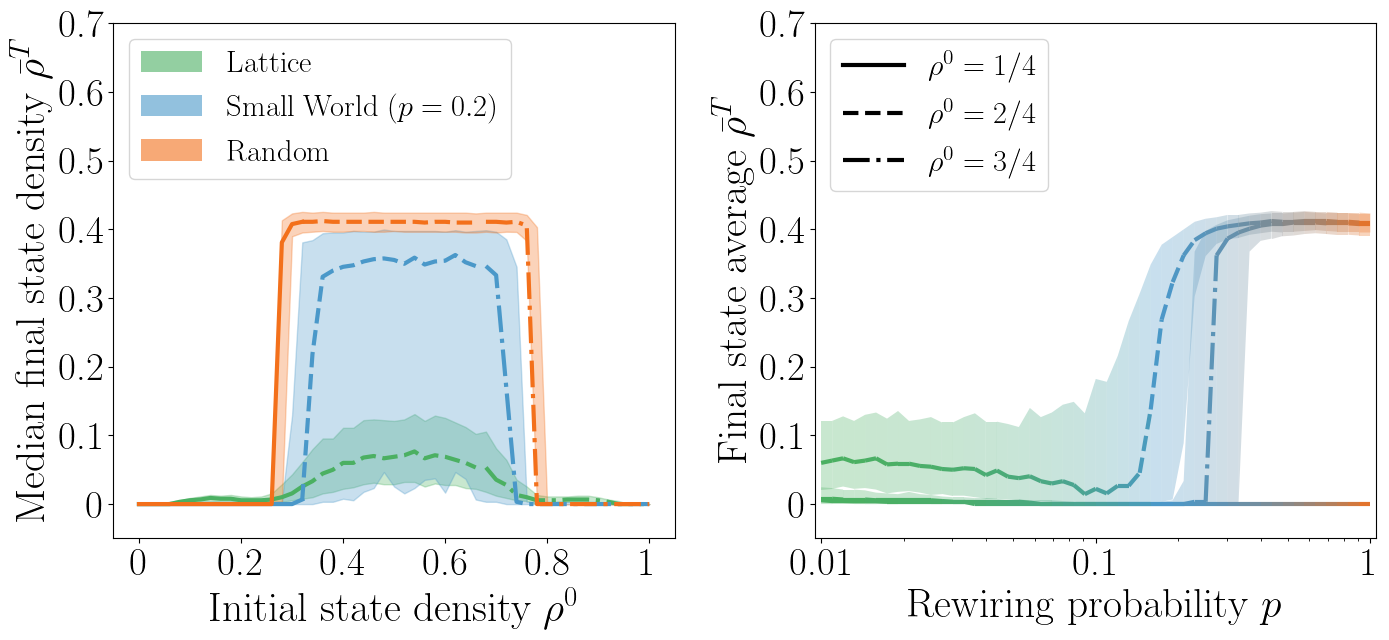

In [34]:
SAVEFIG = True

from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import  ListedColormap
from matplotlib.patches import Patch


fig, axs = plt.subplots(1,2,figsize=(14,6.5))
fontsize=30

graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

# Get a colormap with various shades
from matplotlib.cm import get_cmap
cmaps = [get_cmap("Greens"), get_cmap("Blues"), get_cmap("Oranges")]
colors = [[cmap(i) for i in [0.4, 0.6, 0.9]] for cmap in cmaps]
ls_list = ['-', '--', '-.']

# Define base colors
color1 = get_cmap("Greens")(0.6)
color2 = get_cmap("Blues")(0.6)
color3 = get_cmap("Oranges")(0.6)

# Create a log-spaced array from 0.01 → 1, centered at 0.2
log_vals = np.logspace(np.log10(0.01), np.log10(1), 256)
normed = (np.log10(log_vals) - np.log10(0.01)) / (np.log10(1) - np.log10(0.01))

# Design the color gradient: color1 → color2 → color3
# We'll split it at p=0.2 (~ index of p=0.2 in log_vals)
split_idx = 40

# Gradient to color2 then back to color3
colors_left = np.linspace(color1, color2, split_idx)
colors_right = np.linspace(color2, color3, 256 - split_idx)
log_colors = np.vstack([colors_left, colors_right])

# Final colormap
color_cycle = ListedColormap(log_colors, name="log_cycle")

for median_list, lw_perc_list, up_perc_list, graph_name, cmap in zip(median_list_per_graph,
                                                               lw_perc_list_per_graph,
                                                               up_perc_list_per_graph,
                                                               graph_names,
                                                               cmaps):
    length = len(init_dens_array)
    axs[0].plot(init_dens_array[:length//3], median_list[:length//3],
                lw=3, label=graph_name, color=cmap(0.6), ls=ls_list[0])
    axs[0].plot(init_dens_array[length//3-1:2*length//3], median_list[length//3-1:2*length//3],
                lw=3, color=cmap(0.6), ls=ls_list[1])
    axs[0].plot(init_dens_array[2*length//3:], median_list[2*length//3:],
                lw=3, color=cmap(0.6), ls=ls_list[2])
    axs[0].fill_between(init_dens_array, lw_perc_list, up_perc_list, alpha=0.3, color=cmap(0.6))

label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]

greys = [get_cmap("Greys")(i) for i in [0.5, 0.7, 0.9]]

for median_list, lw_perc_list, up_perc_list, init_dens, label, ls, color in zip(median_list_per_init_dens,
                                                                      lw_perc_list_per_init_dens,
                                                                      up_perc_list_per_init_dens,
                                                                      init_dens_list,
                                                                      label_list,
                                                                      ls_list,
                                                                      greys):
    x = np.array(rewiring_prob_array)
    y = np.array(median_list)
    y1 = np.array(lw_perc_list)
    y2 = np.array(up_perc_list)

    # Line segments for gradient curve
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(0.01, 1.0)  # or x.min(), x.max() if x = rewiring_prob_array
    lc = LineCollection(segments, cmap=color_cycle, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(3)
    lc.set_linestyle(ls)
    axs[1].add_collection(lc)

    # Gradient fill under the curve
    verts = []
    colors = []
    for i in range(len(x) - 1):
        verts.append([
            (x[i], y1[i]),
            (x[i], y2[i]),
            (x[i+1], y2[i+1]),
            (x[i+1], y1[i+1])
        ])
        colors.append(color_cycle(norm((x[i] + x[i+1]) / 2)))

    poly = PolyCollection(verts, facecolors=colors, edgecolors='none', alpha=0.3)
    axs[1].add_collection(poly)
    axs[1].set_xscale('log')

axs[0].set_ylabel("Median final state density $\\bar{\\rho}^T$", fontsize=fontsize)
axs[0].set_xlabel("Initial state density $\\rho^0$", fontsize=fontsize)

# Sample fill colors at p = 0.01, 0.2, 1.0
fill_colors = [color1, color2, color3]

# Create square color blocks for legend
legend_handles = [
    Patch(facecolor=fc, alpha=0.6, label=graph_name, linewidth=0.5)
    for fc, graph_name in zip(fill_colors, graph_names)
]

axs[0].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')

axs[0].set_ylim([-0.05,0.7])
axs[0].set_xlim([-0.05, 1.05])

# left plot
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-2)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks, fontsize=fontsize-2)

# Create proxy lines for legend
from matplotlib.lines import Line2D
label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]
legend_handles = [
    Line2D([0], [0],
           color='k',
           linestyle=ls,
           linewidth=3,
           label=label)
    for ls, label in zip(ls_list, label_list)
]
axs[1].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')
axs[1].set_ylabel("Final state average $\\bar{\\rho}^T$", fontsize=fontsize)
axs[1].set_xlabel(f"Rewiring probability $p$", fontsize=fontsize)
axs[1].set_ylim([-0.05,0.7])
axs[1].set_xlim([0.01*0.95, 1*1.05])
xticks = [0.01, 0.1, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# axs[1].set_yscale('log')
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticks, fontsize=fontsize-2)
axs[1].set_yticks(yticks)
axs[1].set_yticklabels(yticks, fontsize=fontsize-2)

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}\nFinal state densities depend on initial configuration and topology", fontsize=fontsize+2, y=1)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

if SAVEFIG:
    savename = f"final_state_densities_vs_init_conf_and_topology_{model.__str__()}.pdf"
    plt.savefig(f"{savename}", bbox_inches='tight')

C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\67069741.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


(np.float64(0.267004), np.float64(0.004874), np.float64(0.329415), np.float64(1.0))
(np.float64(0.127568), np.float64(0.566949), np.float64(0.550556), np.float64(1.0))
(np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0))


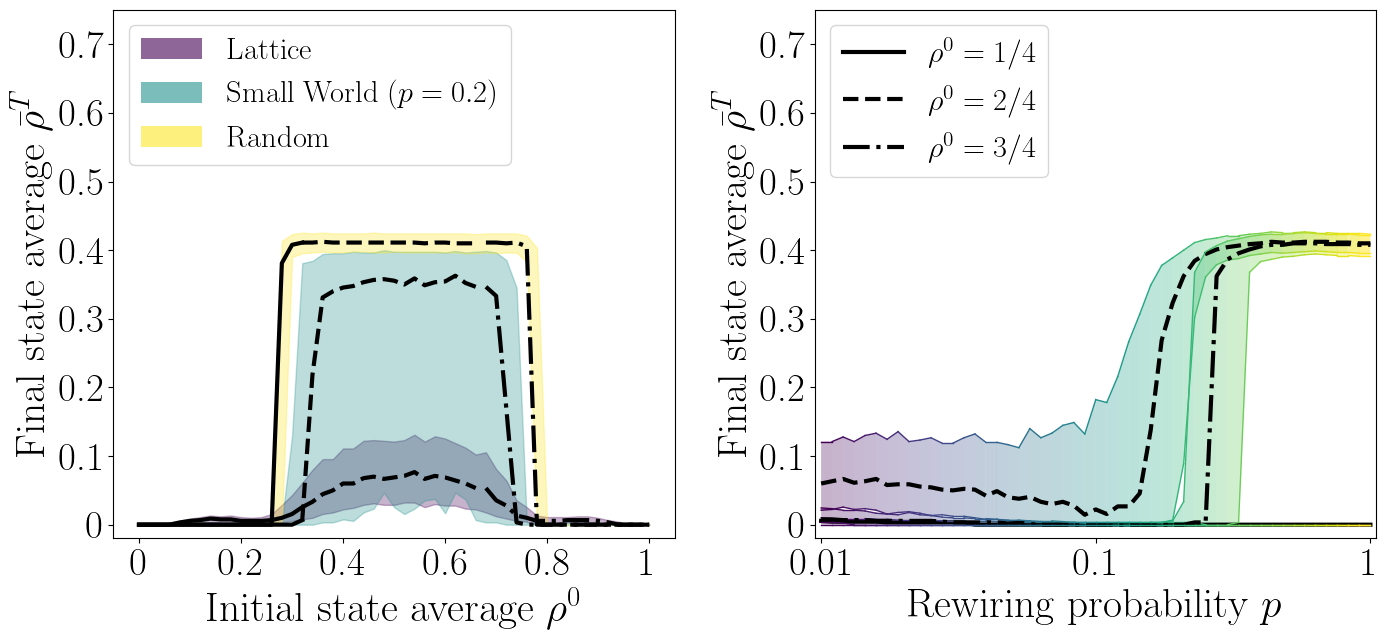

In [35]:
SAVEFIG = True

from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import  LinearSegmentedColormap
from matplotlib.patches import Patch

fig, axs = plt.subplots(1,2,figsize=(14,6.5))
fontsize=30

graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

# Get a colormap with various shades
from matplotlib.cm import get_cmap
cmap = get_cmap("viridis")
colors = [cmap(0.0), cmap(.5), cmap(1.0)]
ls_list = ['-', '--', '-.']

# interpolated_colors = LinearSegmentedColormap.from_list("custom_triple", [color1, color2, color3], N=50)
array_length = len(rewiring_prob_array)
interpolated_colors = [cmap(i) for i in np.linspace(0, 1, array_length-1)]

for median_list, lw_perc_list, up_perc_list, graph_name, color in zip(median_list_per_graph,
                                                               lw_perc_list_per_graph,
                                                               up_perc_list_per_graph,
                                                               graph_names,
                                                               colors):
    print(color)
    length = len(init_dens_array)
    axs[0].plot(init_dens_array[:length//3], median_list[:length//3],
                lw=3, label=graph_name, color='k', ls=ls_list[0])
    axs[0].plot(init_dens_array[length//3-1:2*length//3], median_list[length//3-1:2*length//3],
                lw=3, color='k', ls=ls_list[1])
    axs[0].plot(init_dens_array[2*length//3:], median_list[2*length//3:],
                lw=3, color='k', ls=ls_list[2])
    axs[0].fill_between(init_dens_array, lw_perc_list, up_perc_list, alpha=.3, color=color)

label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]

for median_list, lw_perc_list, up_perc_list, init_dens, label, ls in zip(median_list_per_init_dens,
                                                                      lw_perc_list_per_init_dens,
                                                                      up_perc_list_per_init_dens,
                                                                      init_dens_list,
                                                                      label_list,
                                                                      ls_list):
    axs[1].plot(np.log10(rewiring_prob_array), median_list, color='k', lw=3, ls=ls)
    for i in range(len(rewiring_prob_array[:-1])):
        color = interpolated_colors[i]
        axs[1].plot(np.log10(rewiring_prob_array[i:i+2]), lw_perc_list[i:i+2], color=color, lw=1, ls='-')
        axs[1].plot(np.log10(rewiring_prob_array[i:i+2]), up_perc_list[i:i+2], color=color, lw=1, ls='-')
        axs[1].fill_between(np.log10(rewiring_prob_array[i:i+2]), lw_perc_list[i:i+2], up_perc_list[i:i+2],
                            color=color, alpha=0.3, edgecolor='none')

axs[0].set_ylabel("Final state average $\\bar{\\rho}^T$", fontsize=fontsize)
axs[0].set_xlabel("Initial state average $\\rho^0$", fontsize=fontsize)

# Create square color blocks for legend
legend_handles = [
    Patch(facecolor=fc, alpha=0.6, label=graph_name, linewidth=0.5)
    for fc, graph_name in zip(colors, graph_names)
]

axs[0].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')

axs[0].set_ylim([-0.02,0.75])
axs[0].set_xlim([-0.05, 1.05])

# left plot
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-2)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks, fontsize=fontsize-2)

# Create proxy lines for legend
from matplotlib.lines import Line2D
label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]
legend_handles = [
    Line2D([0], [0],
           color='k',
           linestyle=ls,
           linewidth=3,
           label=label)
    for ls, label in zip(ls_list, label_list)
]
axs[1].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')
axs[1].set_ylabel("Final state average $\\bar{\\rho}^T$", fontsize=fontsize)
axs[1].set_xlabel(f"Rewiring probability $p$", fontsize=fontsize)
axs[1].set_ylim([-0.02,0.75])
axs[1].set_xlim(np.log10([0.01*0.95, 1*1.05]))
# xticks = np.log10([0.01, 0.05, 0.1, 0.5, 1])
xticks = np.log10([0.01, 0.1, 1])
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# axs[1].set_xscale('log')
axs[1].set_xticks(xticks)
# xticklabels = ["0.01", "0.05", "0.1", "0.5", "1"]
xticklabels = ["0.01", "0.1", "1"]
axs[1].set_xticklabels(xticklabels, fontsize=fontsize-2)
axs[1].set_yticks(yticks)
axs[1].set_yticklabels(yticks, fontsize=fontsize-2)

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}\nFinal state densities depend on initial configuration and topology", fontsize=fontsize+2, y=1)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

if SAVEFIG:
    savename = f"final_state_densities_vs_init_conf_and_topology_{model.__str__()}.pdf"
    plt.savefig(f"{savename}", bbox_inches='tight')

### Defect average evolution

**The example time series**

In [ ]:
# make real-sized networks NOTE takes a while

# Parameters
L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
rewiring_prob = 0.2     # Rewiring probability
num_graphs = 30

# Create toroidal lattice and rewire
lattice_graphs = [create_2d_torus_lattice(L, degree=8)]*num_graphs
small_world_graphs = [watts_strogatz_rewire(lattice_graphs[0], rewiring_prob) for _ in range(num_graphs)]
random_graphs = [watts_strogatz_rewire(lattice_graphs[0], 1.) for _ in range(num_graphs)]

# find edges for lattice graph
lattice_graph = lattice_graphs[0]
lattice_graph.to_directed()
lattice_edges = [tc.tensor(lattice_graph.get_edgelist()).T]*num_graphs
lattice_graph.to_undirected()

# find edges for small world graph
small_world_edges = []
for small_world_graph in small_world_graphs:
    small_world_graph.to_directed()
    small_world_edges.append(tc.tensor(small_world_graph.get_edgelist()).T)
    small_world_graph.to_undirected()

# find edges for random graph
random_edges = []
for random_graph in random_graphs:
    random_graph.to_directed()
    random_edges.append(tc.tensor(random_graph.get_edgelist()).T)
    random_graph.to_undirected()

edges_list = [lattice_edges, small_world_edges, random_edges]
graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

In [37]:
RUN_AGAIN = False

if RUN_AGAIN:

    # choose LLCA that will be topologically generalised
    life_like_dict = return_life_like_dict()
    like_like_rule = "morley"

    resolution = 9
    beta, sigma = life_like_dict[like_like_rule]
    B_set = binary_indices(beta)
    S_set = binary_indices(sigma)
    model = LLNA(resolution, B_set, S_set, iso=True)

    num_nodes = L**2
    T = 100 # num_nodes // 10

    def init_config_with_dens(N, dens):
        # defines a random initial configuration with a fixed state density
        s0 = np.zeros(N, dtype=int)
        s0[:np.round(dens*N).astype(int)] = 1.
        np.random.shuffle(s0)
        return s0

    num_config = 30
    init_dens_list = [0.25, 0.5, 0.75]
    init_dens_str_list = [f'1/4', f'2/4', f'3/4']
    init_dens_colors = ['olive', 'maroon', 'dodgerblue']
    ls_list = ['-', '--', '-.']

    metadata = {
        "resolution": resolution,
        "beta": beta,
        "sigma": sigma,
        "num_nodes": num_nodes,
        "num_config": num_config,
        "num_graphs": num_graphs,
        "T": T
    }

    # Create file in "append" mode (if it exists, it will be opened; if not, it will be created)
    with h5py.File('../data/defect_density_time_series.h5', 'a') as f:
        # Create nested groups using metadata   
        group_path = f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
        group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"

        # iterate over graph types
        for edges, graph_name in zip(edges_list, graph_names):
            print(f"Processing graph type: {graph_name}")
            # iterate over three distinct initial densities
            for init_dens, init_dens_str, color, ls in tqdm(zip(init_dens_list, init_dens_str_list, init_dens_colors, ls_list), total=len(init_dens_list)):
                # make empty array for defect averages
                defect_averages = np.empty((T+1,0))
                # iterate over particular graphs within each type
                for edge in edges:
                    # for each graph, make some random initial configurations with the given density
                    init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                    # find a number of unique defects. We can use the same function for this
                    init_configs_defects = np.eye(num_nodes, dtype=int)[np.random.randint(0,num_nodes,num_config)]
                    # create an initial configuration with the appropriate damage
                    init_configs_damage = np.bitwise_xor(init_configs, init_configs_defects)
                    # run simulation over a number of time steps
                    configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                    configs_damage = model.forward(edge, tc.tensor(init_configs_damage), T=T).numpy().astype(int)
                    damage = np.bitwise_xor(configs, configs_damage)
                    # calculate the mean damage over all nodes
                    current_defect_averages = np.mean(damage, axis=2).T
                    # vertically stack the means for all graphs
                    defect_averages = np.hstack((defect_averages, current_defect_averages))
                # calcule the quartiles for each time step as time series
                q1_of_means = np.quantile(defect_averages, 0.25, axis=1)
                q2_of_means = np.quantile(defect_averages, .50, axis=1)
                q3_of_means = np.quantile(defect_averages, 0.75, axis=1)

                # Save array inside the group
                group_path_current = group_path + f"/{graph_name.replace(' ', '_')}/init_dens_{init_dens_str.replace('/', 'f')}"
                group = f.create_group(group_path_current)

                group.create_dataset('q1_of_means', data=q1_of_means)
                group.create_dataset('q2_of_means', data=q2_of_means)
                group.create_dataset('q3_of_means', data=q3_of_means)

C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\501556218.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


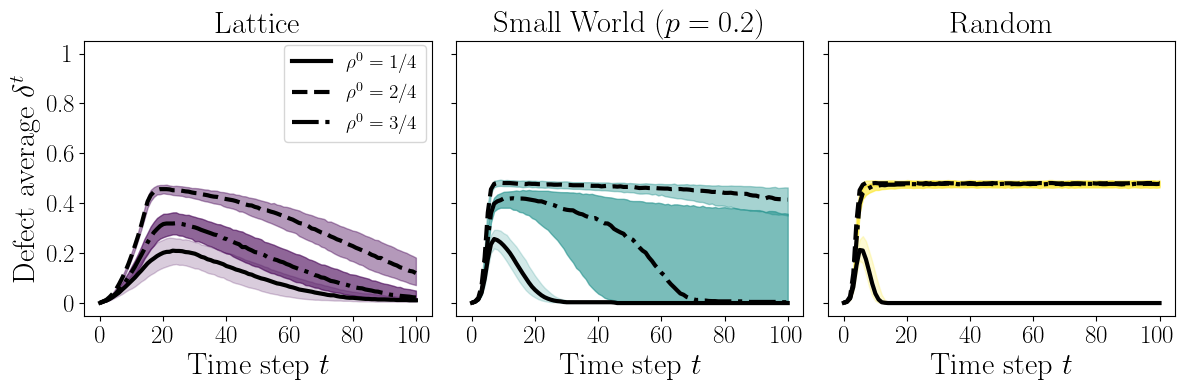

In [38]:
SAVEFIG = True
savename_prefix = "defect-average-evolution_three-networks_"

metadata = {
    "resolution": 9,
    "beta": 328,
    "sigma": 52,
    "num_nodes": 900,
    "num_config": 30,
    "num_graphs": 30,
    "T": 100
}

fig, axs = plt.subplots(1, len(graph_names), figsize=(4*len(graph_names), 4), sharey=True)
fontsize=22
alpha_factor = 0.05

# Get a colormap with green shades
from matplotlib.cm import get_cmap
cmap = get_cmap("viridis")
colors = [cmap(0.0), cmap(0.5), cmap(1.0)]  # Use specific colors from the colormap
alphas = [0.2, 0.4, 0.6]
ls_list = ['-', '--', '-.']

### look at tree structure
def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/ (Group)")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

# with h5py.File('data/defect_density_time_series.h5', 'r') as f:
#     f.visititems(print_h5_tree)

# Open the file in read mode
with h5py.File('../data/defect_density_time_series.h5', 'r') as f:
    ### load data for various initial state densities
    # Navigate to the correct group path
    group_path = (
        f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
        f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
    )
    
    for ax, graph_name, color in zip(axs, graph_names, colors):
        for init_dens_str, alpha, ls in zip(init_dens_str_list, alphas, ls_list):

            group_path_current = group_path + f"/{graph_name.replace(' ', '_')}/init_dens_{init_dens_str.replace('/', 'f')}"

            # Access the group
            group_current = f[group_path_current]
            # Load datasets
            q1_of_means = group_current['q1_of_means'][:]
            q2_of_means = group_current['q2_of_means'][:]
            q3_of_means = group_current['q3_of_means'][:]

            # ax.plot(means_over_nodes, alpha=alpha_factor*100/num_config, color=color)
            ax.plot(q2_of_means, lw=3, color='k', ls=ls, label=f"$\\rho^0 = {init_dens_str}$")
            ax.fill_between(range(metadata['T']+1), q1_of_means, q3_of_means, lw=1, color=color, alpha=alpha)
            ax.set_title(f"{graph_name}", fontsize=fontsize)
            ax.set_xlabel("Time step $t$", fontsize=fontsize)
            ax.set_ylim([-0.05, 1.05])
            yticks = [0, .2, .4, .6, .8, 1]
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize-4)
            xticks = [0, 20, 40, 60, 80, 100]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, fontsize=fontsize-4)
            axs[0].set_ylabel("Defect average $\\delta^t$", fontsize=fontsize)

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
# Create black handles (same style, but black color)
from matplotlib.lines import Line2D
black_handles = [
    Line2D([0], [0],
           color='black', 
           linestyle=h.get_linestyle(), 
           marker=h.get_marker(), 
           linewidth=h.get_linewidth(),
           markersize=h.get_markersize())
    for h in handles
]
fig.legend(black_handles, labels, loc='upper right', ncol=1, fontsize=fontsize-8, bbox_to_anchor=(.367, 0.90) )

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}", fontsize=fontsize+2, x=0.3, y=.985)
fig.tight_layout()

savename = savename_prefix + model.__str__() + ".pdf"

if SAVEFIG:
    plt.savefig(f"../figures/{savename}", bbox_inches='tight')

**Convergence values of $\delta^0$**

Calculate final defect density in function of initial density for three networks

In [39]:
from analysis import median_and_percentiles_over_ensemble
import h5py

In [40]:
RUN_AGAIN = False
SAVEDATA = False
# takes a long time!

if RUN_AGAIN:

    T = 100

    resolution = 9
    beta, sigma = life_like_dict["morley"]
    B_set = binary_indices(beta)
    S_set = binary_indices(sigma)
    model = LLNA(resolution, B_set, S_set, iso=True)

    def init_config_with_dens(N, dens):
        # defines a random initial configuration with a fixed state density
        s0 = np.zeros(N, dtype=int)
        s0[:np.round(dens*N).astype(int)] = 1.
        np.random.shuffle(s0)
        return s0

    # Parameters
    L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
    num_nodes = L**2
    rewiring_prob = 0.2     # Rewiring probability
    num_graphs = 30

    # TODO: average over a number of graphs (not only over initial configurations)

    # Create toroidal lattice and rewire
    lattice_graphs = [create_2d_torus_lattice(L, degree=8)]*num_graphs
    small_world_graphs = [watts_strogatz_rewire(lattice_graphs[0], rewiring_prob) for _ in range(num_graphs)]
    random_graphs = [watts_strogatz_rewire(lattice_graphs[0], 1.) for _ in range(num_graphs)]

    # find edges for lattice graph
    lattice_graph = lattice_graphs[0]
    lattice_graph.to_directed()
    lattice_edges = [tc.tensor(lattice_graph.get_edgelist()).T]*num_graphs
    lattice_graph.to_undirected()

    # find edges for small world graph
    small_world_edges = []
    for small_world_graph in small_world_graphs:
        small_world_graph.to_directed()
        small_world_edges.append(tc.tensor(small_world_graph.get_edgelist()).T)
        small_world_graph.to_undirected()

    # find edges for random graph
    random_edges = []
    for random_graph in random_graphs:
        random_graph.to_directed()
        random_edges.append(tc.tensor(random_graph.get_edgelist()).T)
        random_graph.to_undirected()

    edges_list = [lattice_edges, small_world_edges, random_edges]

    num_config = 30
    init_dens_res = 51
    init_dens_array = np.linspace(0,1,init_dens_res)
    delta_t = 10

    damage_list_per_init_dens_per_graph = []
    median_list_per_graph = []
    lw_perc_list_per_graph = []
    up_perc_list_per_graph = []
    for i, edges in enumerate(edges_list):
        print(f"Working on graph type {i+1}.")
        damage_list_per_init_dens = []
        median_list = []
        lw_perc_list = []
        up_perc_list = []
        for init_dens in tqdm(init_dens_array, total=len(init_dens_array)):
            damage_array = np.empty((0, T+1, num_nodes), dtype=int)
            for edge in edges:
                init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                # find a number of unique defects. We can use the same function for this
                init_configs_defects = np.eye(num_nodes, dtype=int)[np.random.choice(num_nodes, num_config, replace=False)]
                # create an initial configuration with the appropriate damage
                init_configs_damage = np.bitwise_xor(init_configs, init_configs_defects)
                # run simulation over a number of time steps
                configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                # run simulation over a number of time steps for the original and defect thing
                configs_damage = model.forward(edge, tc.tensor(init_configs_damage), T=T).numpy().astype(int)
                # calculate the damage (bitwise xor)
                damage = np.bitwise_xor(configs, configs_damage)
                # add to array
                damage_array = np.vstack((damage_array, damage))
            # calculate the means over all nodes
            means_damage_over_nodes = np.mean(damage_array, axis=2).T
            damage_list_per_init_dens.append(means_damage_over_nodes)
            # calcule the median and quantiles
            median, lw_perc, up_perc = median_and_percentiles_over_ensemble(means_damage_over_nodes, delta_t)
            median_list.append(median)
            lw_perc_list.append(lw_perc)
            up_perc_list.append(up_perc)
        damage_list_per_init_dens_per_graph.append(damage_list_per_init_dens)
        median_list_per_graph.append(median_list)
        lw_perc_list_per_graph.append(lw_perc_list)
        up_perc_list_per_graph.append(up_perc_list)
    damage_list_per_init_dens_per_graph = np.array(damage_list_per_init_dens_per_graph)
    median_list_per_graph = np.array(median_list_per_graph)
    lw_perc_list_per_graph = np.array(lw_perc_list_per_graph)
    up_perc_list_per_graph = np.array(up_perc_list_per_graph)

    if SAVEDATA:
        metadata = {
            "num_nodes": num_nodes,
            "num_config": num_config,
            "T": T,
            "resolution": resolution,
            "beta": beta,
            "sigma": sigma,
            "init_dens_res": init_dens_res,
            "rewiring_prob": rewiring_prob,
            "num_graphs": num_graphs
            }
        # Create file in "append" mode
        with h5py.File('../data/final_defect_densities.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"various_init_state_dens"     
            group_path = group_path + f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
            group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('init_dens_array', data=init_dens_array)
            group.create_dataset('damage_list_per_init_dens_per_graph', data=damage_list_per_init_dens_per_graph)
            group.create_dataset('median_list_per_graph', data=median_list_per_graph)
            group.create_dataset('lw_perc_list_per_graph', data=lw_perc_list_per_graph)
            group.create_dataset('up_perc_list_per_graph', data=up_perc_list_per_graph)

In [41]:
RUN_AGAIN = False
SAVEDATA = False
# takes a long time

if RUN_AGAIN:

    # Parameters
    L = 30                  # Grid size (L x L) WATCH OUT with values, becomes intensive fast
    num_nodes = L**2
    num_graphs = 30
    rewiring_res = 51
    rewiring_prob_array = np.logspace(-2,0,rewiring_res) # logarithmically distributed between 0.01 and 1

    # Create toroidal lattice and rewire
    lattice_graph = create_2d_torus_lattice(L, degree=8)
    print(f"Creating {num_graphs} graphs of {num_nodes} nodes for each rewiring probability.")
    graphs = [[watts_strogatz_rewire(lattice_graph, rewiring_prob) for _ in range(num_graphs)] for rewiring_prob in tqdm(rewiring_prob_array, total=rewiring_res)]
    edges = []
    for i, rewiring_prob in enumerate(rewiring_prob_array):
        edges_per_rewiring_prob = []
        for graph in graphs[i]:
            # find edges
            graph.to_directed()
            edge = tc.tensor(graph.get_edgelist()).T
            edges_per_rewiring_prob.append(edge)
            graph.to_undirected()
        edges.append(edges_per_rewiring_prob)

    num_config = 30
    delta_t = 10

    init_dens_list = [0.25, 0.5, 0.75]
    damage_list_per_rewiring_prob_per_init_dens = []
    median_list_per_init_dens = []
    lw_perc_list_per_init_dens = []
    up_perc_list_per_init_dens = []
    for i, init_dens in enumerate(init_dens_list):
        print(f"Working on init_dens value {i+1}.")
        damage_list_per_rewiring_prob = []
        median_list = []
        lw_perc_list = []
        up_perc_list = []
        for edges_per_rewiring_prob in tqdm(edges, total=len(edges)):
            damage_array = np.empty((0, T+1, num_nodes), dtype=int)
            for edge in edges_per_rewiring_prob:
                init_configs = np.array([init_config_with_dens(num_nodes, init_dens) for _ in range(num_config)])
                # find a number of unique defects. We can use the same function for this
                init_configs_defects = np.eye(num_nodes, dtype=int)[np.random.choice(num_nodes, num_config, replace=False)]
                # create an initial configuration with the appropriate damage
                init_configs_damage = np.bitwise_xor(init_configs, init_configs_defects)
                # run simulation over a number of time steps for the original and defect thing
                configs = model.forward(edge, tc.tensor(init_configs), T=T).numpy().astype(int)
                configs_damage = model.forward(edge, tc.tensor(init_configs_damage), T=T).numpy().astype(int)
                # calculate the damage (bitwise xor)
                damage = np.bitwise_xor(configs, configs_damage)
                # add to array
                damage_array = np.vstack((damage_array, damage))
            # calculate the means over all nodes
            means_damage_over_nodes = np.mean(damage_array, axis=2).T
            damage_list_per_rewiring_prob.append(means_damage_over_nodes)
            # calculate the median and quantiles
            median, lw_perc, up_perc = median_and_percentiles_over_ensemble(means_damage_over_nodes, delta_t)
            median_list.append(median)
            lw_perc_list.append(lw_perc)
            up_perc_list.append(up_perc)
        damage_list_per_rewiring_prob_per_init_dens.append(damage_list_per_rewiring_prob)
        median_list_per_init_dens.append(median_list)
        lw_perc_list_per_init_dens.append(lw_perc_list)
        up_perc_list_per_init_dens.append(up_perc_list)
    damage_list_per_rewiring_prob_per_init_dens = np.array(damage_list_per_rewiring_prob_per_init_dens)
    median_list_per_init_dens = np.array(median_list_per_init_dens)
    lw_perc_list_per_init_dens = np.array(lw_perc_list_per_init_dens)
    up_perc_list_per_init_dens = np.array(up_perc_list_per_init_dens)

    if SAVEDATA:
        metadata = {
            "num_nodes": num_nodes,
            "num_config": num_config,
            "T": T,
            "resolution": resolution,
            "beta": beta,
            "sigma": sigma,
            "init_dens_res": init_dens_res,
            "rewiring_prob": rewiring_prob,
            "num_graphs": num_graphs
            }
        # Create file in "append" mode
        with h5py.File('../data/final_defect_densities.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"various_rewiring_probs"     
            group_path = group_path + f"/r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}"
            group_path = group_path + f"/N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('rewiring_prob_array', data=rewiring_prob_array)
            group.create_dataset('init_dens_list', data=init_dens_list)
            group.create_dataset('damage_list_per_rewiring_prob_per_init_dens', data=damage_list_per_rewiring_prob_per_init_dens)
            group.create_dataset('median_list_per_init_dens', data=median_list_per_init_dens)
            group.create_dataset('lw_perc_list_per_init_dens', data=lw_perc_list_per_init_dens)
            group.create_dataset('up_perc_list_per_init_dens', data=up_perc_list_per_init_dens)

In [42]:
LOADDATA = True

metadata = {
    "num_nodes": 900,
    "num_config": 30,
    "T": 100,
    "resolution": 9,
    "beta": 328,
    "sigma": 52,
    "init_dens_res": 51,
    "rewiring_prob": 0.2,
    "num_graphs": 30
    }

if LOADDATA:
    ### look at tree structure
    def print_h5_tree(name, obj):
        indent = "  " * name.count('/')
        if isinstance(obj, h5py.Group):
            print(f"{indent}{name}/ (Group)")
        elif isinstance(obj, h5py.Dataset):
            print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

    with h5py.File('../data/final_defect_densities.h5', 'r') as f:
        f.visititems(print_h5_tree)
    
    # Open the file in read mode
    with h5py.File('../data/final_defect_densities.h5', 'r') as f:
        ### load data for various initial state densities
        # Navigate to the correct group path
        group_path = (
            "various_init_state_dens/"
            f"r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}/"
            f"N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
        )
        # Access the group
        group = f[group_path]
        # Load datasets
        init_dens_array = group['init_dens_array'][:]
        damage_list_per_init_dens_per_graph = group['damage_list_per_init_dens_per_graph'][:]
        median_list_per_graph = group['median_list_per_graph'][:]
        lw_perc_list_per_graph = group['lw_perc_list_per_graph'][:]
        up_perc_list_per_graph = group['up_perc_list_per_graph'][:]

        ### load data for various rewiring probabilities
        group_path = (
            "various_rewiring_probs/"
            f"r{metadata['resolution']}beta{metadata['beta']}sigma{metadata['sigma']}/"
            f"N{metadata['num_nodes']}T{metadata['T']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
        )
        # Access the group
        group = f[group_path]
        # Load datasets
        init_dens_list = group['init_dens_list'][:]
        rewiring_prob_array = group['rewiring_prob_array'][:]
        damage_list_per_graph_per_init_dens = group['damage_list_per_rewiring_prob_per_init_dens'][:]
        median_list_per_init_dens = group['median_list_per_init_dens'][:]
        lw_perc_list_per_init_dens = group['lw_perc_list_per_init_dens'][:]
        up_perc_list_per_init_dens = group['up_perc_list_per_init_dens'][:]


various_init_state_dens/ (Group)
  various_init_state_dens/r9beta328sigma52/ (Group)
    various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/ (Group)
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/damage_list_per_init_dens_per_graph (Dataset) shape=(3, 51, 101, 900), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/init_dens_array (Dataset) shape=(51,), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/lw_perc_list_per_graph (Dataset) shape=(3, 51), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/median_list_per_graph (Dataset) shape=(3, 51), dtype=float64
      various_init_state_dens/r9beta328sigma52/N900T100M30num_graphs30/up_perc_list_per_graph (Dataset) shape=(3, 51), dtype=float64
    various_init_state_dens/r9beta328sigma52/N900T100M3num_graphs3/ (Group)
      various_init_state_dens/r9beta328sigma52/N900T100M3num_graphs3/damage_list_pe

### Relationship between state average and defect average

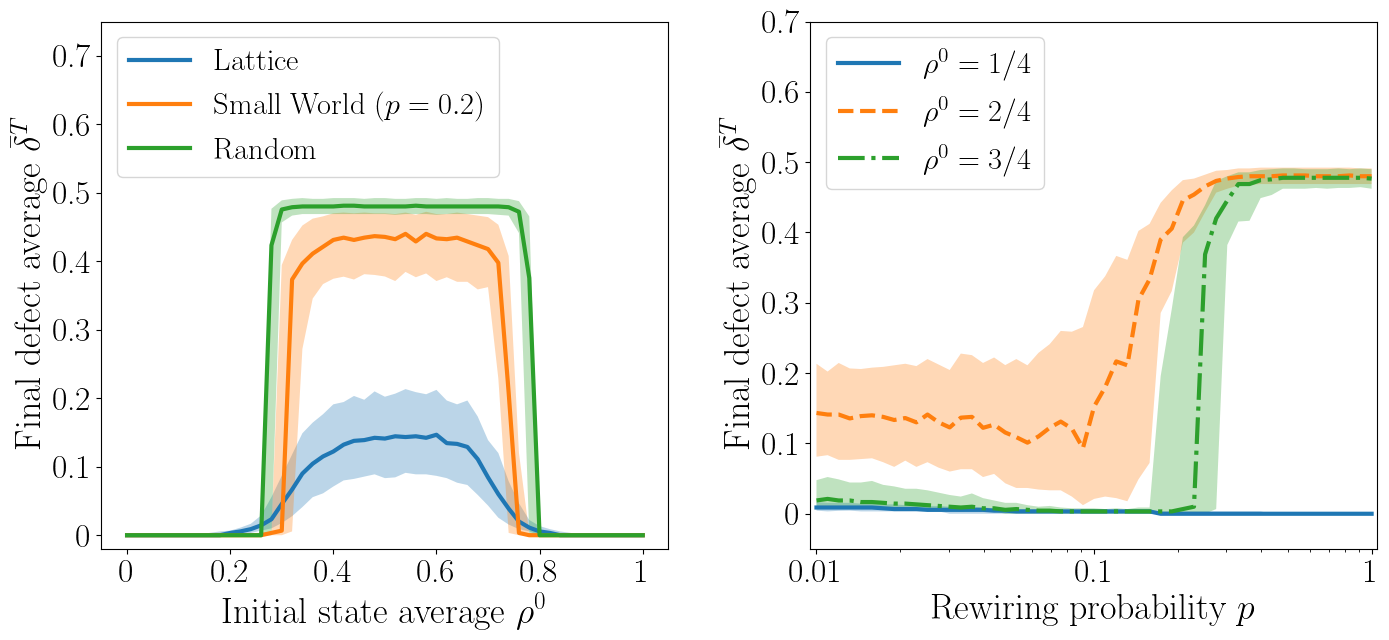

In [ ]:
SAVEFIG = True

fig, axs = plt.subplots(1,2,figsize=(14,6.5))
fontsize=26

graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

for median_list, lw_perc_list, up_perc_list, graph_name in zip(median_list_per_graph,
                                                               lw_perc_list_per_graph,
                                                               up_perc_list_per_graph,
                                                               graph_names):
    axs[0].plot(init_dens_array, median_list, lw=3, label=graph_name)
    axs[0].fill_between(init_dens_array, lw_perc_list, up_perc_list, alpha=0.3)

label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]
ls_list = ['-', '--', '-.']

for median_list, lw_perc_list, up_perc_list, init_dens, label, ls in zip(median_list_per_init_dens,
                                                                      lw_perc_list_per_init_dens,
                                                                      up_perc_list_per_init_dens,
                                                                      init_dens_list,
                                                                      label_list,
                                                                      ls_list):
    axs[1].plot(rewiring_prob_array, median_list, lw=3, ls=ls, label=label)
    axs[1].fill_between(rewiring_prob_array, lw_perc_list, up_perc_list, alpha=0.3)
    axs[1].set_xscale('log')

axs[0].set_ylabel("Final defect average $\\bar{\\delta}^T$", fontsize=fontsize)
axs[0].set_xlabel("Initial state average $\\rho^0$", fontsize=fontsize)
axs[0].legend(fontsize=fontsize-4, loc='upper left')

axs[0].set_ylim([-0.02,0.75])
axs[0].set_xlim([-0.05, 1.05])

# left plot
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-2)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks, fontsize=fontsize-2)

# right plot
axs[1].legend(fontsize=fontsize-4, loc='upper left')
axs[1].set_ylabel("Final defect average $\\bar{\\delta}^T$", fontsize=fontsize)
axs[1].set_xlabel(f"Rewiring probability $p$", fontsize=fontsize)
axs[1].set_ylim([-0.05,0.7])
axs[1].set_xlim([0.01*0.95, 1*1.05])
xticks = [0.01, 0.1, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# axs[1].set_yscale('log')
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticks, fontsize=fontsize-2)
axs[1].set_yticks(yticks)
axs[1].set_yticklabels(yticks, fontsize=fontsize-2)

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}\nFinal state densities depend on initial configuration and topology", fontsize=fontsize+2, y=1)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

if SAVEFIG:
    savename = f"../figures/final_defect_densities_vs_init_conf_and_topology_{model.__str__()}.pdf"
    plt.savefig(f"{savename}", bbox_inches='tight')

C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\642127465.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")
C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\642127465.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color1 = get_cmap("Greens")(0.6)
C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\642127465.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color2 = get_cmap("Blues")(0.6)
C:\Users\mrollier\AppData\Loc

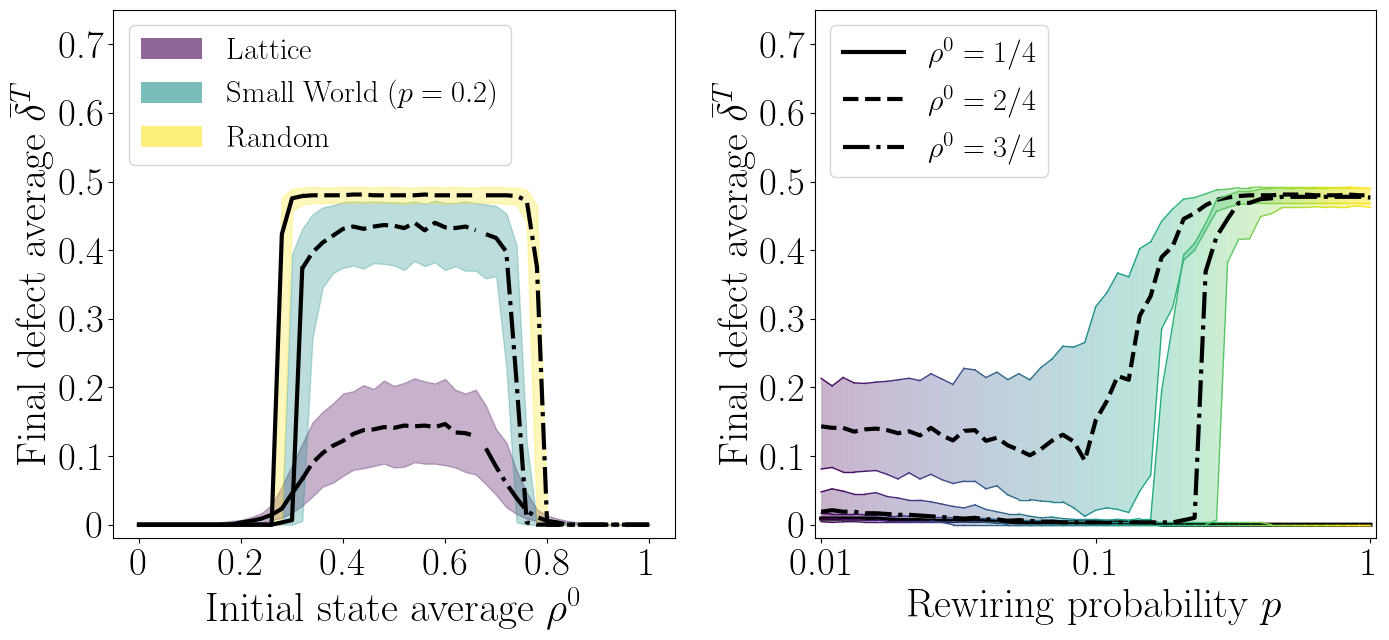

In [ ]:
SAVEFIG = True

from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import  LinearSegmentedColormap
from matplotlib.patches import Patch

fig, axs = plt.subplots(1,2,figsize=(14,6.5))
fontsize=30

graph_names = ["Lattice", f"Small World ($p=0.2$)", "Random"]

# Get a colormap with various shades
from matplotlib.cm import get_cmap
cmap = get_cmap("viridis")
colors = [cmap(0.0), cmap(.5), cmap(1.0)]
ls_list = ['-', '--', '-.']

# Define base colors
color1 = get_cmap("Greens")(0.6)
color2 = get_cmap("Blues")(0.6)
color3 = get_cmap("Oranges")(0.6)

# interpolated_colors = LinearSegmentedColormap.from_list("custom_triple", [color1, color2, color3], N=50)
array_length = len(rewiring_prob_array)
interpolated_colors = [cmap(i) for i in np.linspace(0, 1, array_length-1)]

for median_list, lw_perc_list, up_perc_list, graph_name, color in zip(median_list_per_graph,
                                                               lw_perc_list_per_graph,
                                                               up_perc_list_per_graph,
                                                               graph_names,
                                                               colors):
    length = len(init_dens_array)
    axs[0].plot(init_dens_array[:length//3], median_list[:length//3],
                lw=3, label=graph_name, color='k', ls=ls_list[0])
    axs[0].plot(init_dens_array[length//3-1:2*length//3], median_list[length//3-1:2*length//3],
                lw=3, color='k', ls=ls_list[1])
    axs[0].plot(init_dens_array[2*length//3:], median_list[2*length//3:],
                lw=3, color='k', ls=ls_list[2])
    axs[0].fill_between(init_dens_array, lw_perc_list, up_perc_list, alpha=0.3, color=color)

label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]

for median_list, lw_perc_list, up_perc_list, init_dens, label, ls, color in zip(median_list_per_init_dens,
                                                                      lw_perc_list_per_init_dens,
                                                                      up_perc_list_per_init_dens,
                                                                      init_dens_list,
                                                                      label_list,
                                                                      ls_list,
                                                                      greys):
    axs[1].plot(np.log10(rewiring_prob_array), median_list, color='k', lw=3, ls=ls)
    for i in range(len(rewiring_prob_array[:-1])):
        color = interpolated_colors[i]
        axs[1].plot(np.log10(rewiring_prob_array[i:i+2]), lw_perc_list[i:i+2], color=color, lw=1, ls='-')
        axs[1].plot(np.log10(rewiring_prob_array[i:i+2]), up_perc_list[i:i+2], color=color, lw=1, ls='-')
        axs[1].fill_between(np.log10(rewiring_prob_array[i:i+2]), lw_perc_list[i:i+2], up_perc_list[i:i+2],
                            color=color, alpha=0.3, edgecolor='none')

axs[0].set_ylabel("Final defect average $\\bar{\\delta}^T$", fontsize=fontsize)
axs[0].set_xlabel("Initial state average $\\rho^0$", fontsize=fontsize)

# Create square color blocks for legend
legend_handles = [
    Patch(facecolor=fc, alpha=0.6, label=graph_name, linewidth=0.5)
    for fc, graph_name in zip(colors, graph_names)
]

axs[0].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')

axs[0].set_ylim([-0.02,0.75])
axs[0].set_xlim([-0.05, 1.05])

# left plot
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-2)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks, fontsize=fontsize-2)

# Create proxy lines for legend
label_list = [f"$\\rho^0 = 1/4$", f"$\\rho^0 = 2/4$", f"$\\rho^0 = 3/4$"]
legend_handles = [
    Line2D([0], [0],
           color='k',
           linestyle=ls,
           linewidth=3,
           label=label)
    for ls, label in zip(ls_list, label_list)
]
axs[1].legend(handles=legend_handles, fontsize=fontsize-8, loc='upper left')
axs[1].set_ylabel("Final defect average $\\bar{\\delta}^T$", fontsize=fontsize)
axs[1].set_xlabel(f"Rewiring probability $p$", fontsize=fontsize)
axs[1].set_ylim([-0.02,0.75])
axs[1].set_xlim(np.log10([0.01*0.95, 1*1.05]))
xticks = np.log10([0.01, 0.1, 1])
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# axs[1].set_xscale('log')
axs[1].set_xticks(xticks)
xticklabels = ["0.01", "0.1", "1"]
axs[1].set_xticklabels(xticklabels, fontsize=fontsize-2)
axs[1].set_yticks(yticks)
axs[1].set_yticklabels(yticks, fontsize=fontsize-2)

# fig.suptitle(f"Local update rule {model.__str__(latex=True)}\nFinal state densities depend on initial configuration and topology", fontsize=fontsize+2, y=1)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

if SAVEFIG:
    savename = f"../figures/final_defect_densities_vs_init_conf_and_topology_{model.__str__()}.pdf"
    plt.savefig(f"{savename}", bbox_inches='tight')

# Empirical relations between rules and behaviour

In [49]:
import h5py

LOADDATA = True

### look at tree structure
def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/ (Group)")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

state_medians_per_type = []
state_q1_per_type = []
state_q3_per_type = []

defect_medians_per_type = []
defect_q1_per_type = []
defect_q3_per_type = []

graph_names = ['toroidal-lattice', 'small-world', 'random']

if LOADDATA:
    for graph_name in graph_names:
        with h5py.File(f'../data/results_{graph_name}.h5', 'r') as f:
            f.visititems(print_h5_tree)
        # Open the file in read mode
        with h5py.File(f'../data/results_{graph_name}.h5', 'r') as f:
            ### load data for various initial state densities
            # Navigate to the correct group path
            group_path = (f"resolution5/{graph_name}/state")
            # Access the group
            group = f[group_path]
            # Load datasets
            state_medians_per_type.append(group['median'][:])
            state_q1_per_type.append(group['q1'][:])
            state_q3_per_type.append(group['q3'][:])

            group_path = (f"resolution5/{graph_name}/defect")
            group = f[group_path]
            # Load datasets
            defect_medians_per_type.append(group['median'][:])
            defect_q1_per_type.append(group['q1'][:])
            defect_q3_per_type.append(group['q3'][:])


resolution5/ (Group)
  resolution5/toroidal-lattice/ (Group)
    resolution5/toroidal-lattice/defect/ (Group)
      resolution5/toroidal-lattice/defect/median (Dataset) shape=(528,), dtype=float64
      resolution5/toroidal-lattice/defect/q1 (Dataset) shape=(528,), dtype=float64
      resolution5/toroidal-lattice/defect/q3 (Dataset) shape=(528,), dtype=float64
    resolution5/toroidal-lattice/state/ (Group)
      resolution5/toroidal-lattice/state/median (Dataset) shape=(528,), dtype=float64
      resolution5/toroidal-lattice/state/q1 (Dataset) shape=(528,), dtype=float64
      resolution5/toroidal-lattice/state/q3 (Dataset) shape=(528,), dtype=float64
resolution5/ (Group)
  resolution5/small-world/ (Group)
    resolution5/small-world/defect/ (Group)
      resolution5/small-world/defect/median (Dataset) shape=(528,), dtype=float64
      resolution5/small-world/defect/q1 (Dataset) shape=(528,), dtype=float64
      resolution5/small-world/defect/q3 (Dataset) shape=(528,), dtype=float64
 

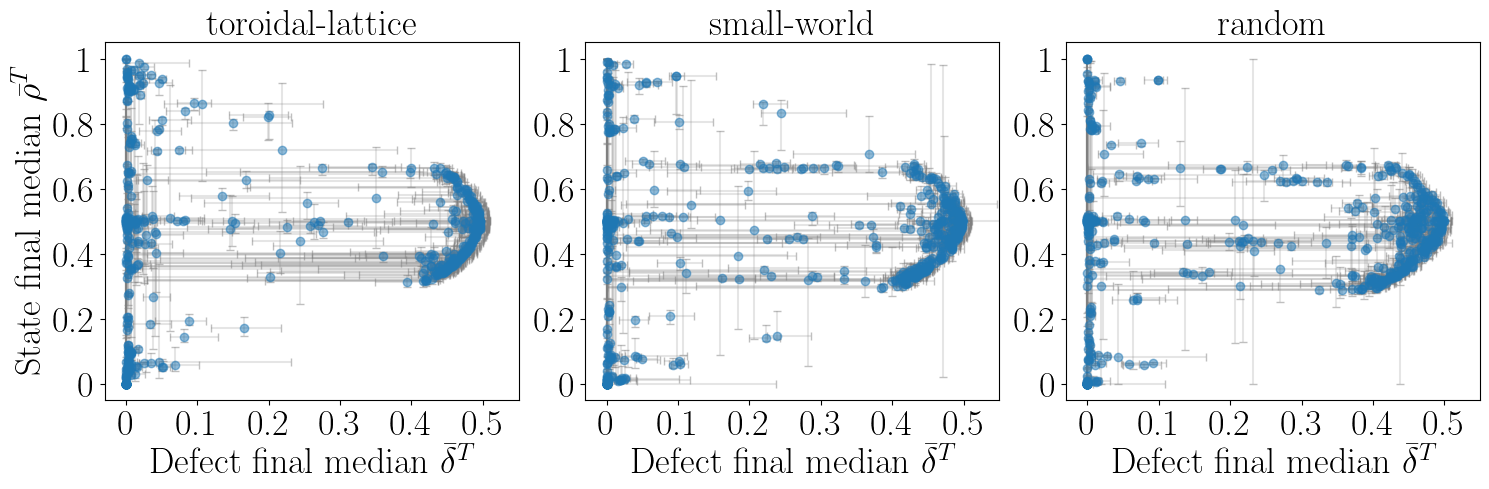

In [50]:
SAVEFIG = True

fig, axs = plt.subplots(1,3,figsize=(15,5))
fontsize=26

for idx, ax in enumerate(axs):
    graph_name = graph_names[idx]
    state_medians = state_medians_per_type[idx]
    state_err = [state_medians - state_q1_per_type[idx], state_q3_per_type[idx] - state_medians]
    defect_medians = defect_medians_per_type[idx]
    defect_err = [defect_medians - defect_q1_per_type[idx], defect_q3_per_type[idx] - defect_medians]

    # Create scatter plot with uncertainty crosses
    eb = ax.errorbar(defect_medians,
                     state_medians,
                     xerr=defect_err,
                     yerr=state_err,
                     fmt='o', ecolor='gray', capsize=3, alpha=0.5)

    # Set alpha for error bars (lines)
    for bar in eb[2]:  # eb[2] is the list of LineCollection objects for error bars
        bar.set_alpha(0.2)  # set your desired alpha for error bars here

    # make nice labels
    ax.set_xlabel('Defect final median $\\bar{\\delta}^T$', fontsize=fontsize)
    # ax.set_ylabel('State final median $\\bar{\\rho}^T$', fontsize=fontsize)
    ax.set_title(graph_name, fontsize=fontsize)

    # get identical limits for each plot
    ax.set_xlim([-0.03,.55])
    ax.set_ylim([-0.05, 1.05])
    xticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=fontsize)
    yticks = [0, .2, .4, .6, .8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize)

axs[0].set_ylabel('State final median $\\bar{\\rho}^T$', fontsize=fontsize)

# fig.suptitle(f"Correlation of phenotype metrics for all $36$ non-equivalent resolution-$3$ rules", fontsize=fontsize+4)
fig.tight_layout()

if SAVEFIG:
    savename = f"../figures/state-median-vs-defect-median_resolution5.pdf"
    plt.savefig(savename, bbox_inches='tight')

In [51]:
# let's compare the sensitivity with the Hamming weight for all NAs

resolution = 5
degree_rules = 8

sigmas=range(2**resolution)
betas=range(2**resolution)

HWs_rules = []
BSs_rules = []
equiv_rule_list = []
for beta in tqdm(betas, total=len(betas)):
    born_if = binary_indices(beta)
    for sigma in sigmas:
        if (beta, sigma) not in equiv_rule_list:
            survive_if = binary_indices(sigma)
            HW = hamming_weight(resolution, born_if, survive_if, degree_rules, norm=True, iso=True)
            BS = boolean_sens(resolution, born_if, survive_if, degree_rules, norm_degree=False, iso=True)
            HWs_rules.append(HW)
            BSs_rules.append(BS)
            # add the equivalent rule to the list
            beta_equiv, sigma_equiv = return_equivalent_rule(resolution, born_if, survive_if, return_decimals=True)
            equiv_rule_list.append((beta_equiv, sigma_equiv))

100%|██████████| 32/32 [00:00<00:00, 41.89it/s]


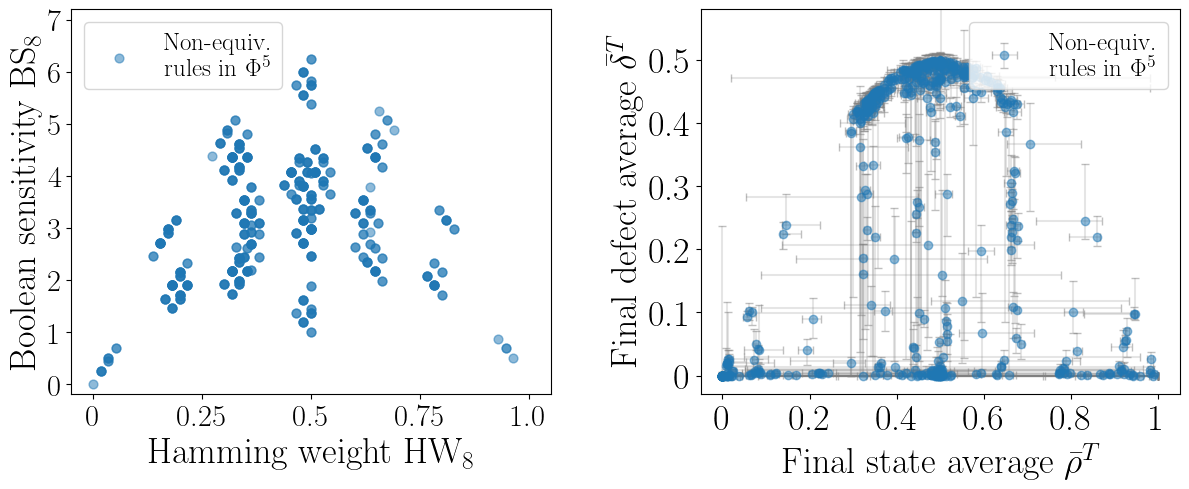

In [52]:
SAVEFIG=False

fig, axs = plt.subplots(1,2,figsize=(12,5))
# label=f"$(\\text{{HW}}_{degree_rules},\\text{{BS}}_{degree_rules})$"
axs[0].scatter(HWs_rules, BSs_rules, s=40, alpha=.5, label=f"Non-equiv.\nrules in $\\Phi^5$")

axs[0].set_xlabel(f"Hamming weight $\\text{{HW}}_8$", fontsize=fontsize)
axs[0].set_ylabel(f"Boolean sensitivity $\\text{{BS}}_8$", fontsize=fontsize)
# ax.set_xlim([-0.05,1.05])
xticks = [0, 0.25, 0.5, 0.75, 1.]
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks, fontsize=fontsize-4)
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks, fontsize=fontsize-4)
# ax.set_aspect(1.0)

yticks = [0, 1, 2, 3, 4, 5, 6, 7]
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks, fontsize=fontsize-4)
axs[0].set_ylim([-0.2, 7.2])

axs[0].legend(fontsize=fontsize-8, loc='upper left')


idx=1

graph_name = graph_names[idx]
state_medians = state_medians_per_type[idx]
state_err = [state_medians - state_q1_per_type[idx], state_q3_per_type[idx] - state_medians]
defect_medians = defect_medians_per_type[idx]
defect_err = [defect_medians - defect_q1_per_type[idx], defect_q3_per_type[idx] - defect_medians]

# Create scatter plot with uncertainty crosses
eb = axs[1].errorbar(state_medians,
                     defect_medians,
                     xerr=state_err,
                     yerr=defect_err,
                     fmt='o', ecolor='gray', capsize=3, alpha=0.5, label=f"Non-equiv.\nrules in $\\Phi^5$")

# Set alpha for error bars (lines)
for bar in eb[2]:  # eb[2] is the list of LineCollection objects for error bars
    bar.set_alpha(0.2)  # set your desired alpha for error bars here

# make nice labels
axs[1].set_xlabel('Final state average $\\bar{\\rho}^T$', fontsize=fontsize)
axs[1].set_ylabel('Final defect average $\\bar{\\delta}^T$', fontsize=fontsize)
# ax.set_ylabel('State final median $\\bar{\\rho}^T$', fontsize=fontsize)
# axs[1].set_title(graph_name, fontsize=fontsize)

# get identical limits for each plot
axs[1].set_ylim([-0.03,.58])
axs[1].set_xlim([-0.05, 1.05])
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
axs[1].set_yticks(yticks)
axs[1].set_yticklabels(yticks, fontsize=fontsize)
xticks = [0, .2, .4, .6, .8, 1]
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticks, fontsize=fontsize)

axs[1].legend(fontsize=fontsize-8, loc='upper right')

fig.tight_layout(w_pad=4)

if SAVEFIG:
    plt.savefig(f"../figures/BS-vs-HW-and-state-vs-defect_median_resolution{resolution}.pdf", bbox_inches='tight')

In [53]:
# PARAMETERS
#####################################################################################################################
L = 30                              # Grid size (L x L) WATCH OUT with values, becomes computationally expensive fast
num_nodes = L**2
rewiring_prob = 0.2                 # Rewiring probability for the small-world network
degree = 8                          # degree for lattice model (Moore neighbourhood)
num_edges = num_nodes * degree // 2 # number of undirected edges
num_graphs_per_type = 30
num_init_conf_per_graph = 30
init_dens = 0.5
T = 100
delta_t = 10
#####################################################################################################################

graph_names = ["Toroidal Lattice", f"Small World", "Random"]

# Create toroidal lattice
lattice_graph = create_2d_torus_lattice(L, degree=degree)
lattice_graphs = [lattice_graph]*num_graphs_per_type

# create small_world graphs. These are connected (see definition)
small_world_graphs = [watts_strogatz_rewire(lattice_graph, rewiring_prob) for _ in range(num_graphs_per_type)]

# create connected random graphs
random_graphs = []
for _ in range(num_graphs_per_type):
    while True:
        random_graph = ig.Graph.Erdos_Renyi(n=num_nodes, m=num_edges)
        if random_graph.is_connected():
            random_graphs.append(random_graph)
            break

# find edges
lattice_edges = []
for lattice_graph in lattice_graphs:
    lattice_graph.to_directed()
    lattice_edge = tc.tensor(lattice_graph.get_edgelist()).T
    lattice_edges.append(lattice_edge)
    lattice_graph.to_undirected()

small_world_edges = []
for small_world_graph in small_world_graphs:
    small_world_graph.to_directed()
    small_world_edge = tc.tensor(small_world_graph.get_edgelist()).T
    small_world_edges.append(small_world_edge)
    small_world_graph.to_undirected()

random_edges = []
for random_graph in random_graphs:
    random_graph.to_directed()
    random_edge = tc.tensor(random_graph.get_edgelist()).T
    random_edges.append(random_edge)
    random_graph.to_undirected()

graphs_per_type = [lattice_graphs, small_world_graphs, random_graphs]
edges_per_type = [lattice_edges, small_world_edges, random_edges]

In [54]:
RUN_AGAIN = False
SAVEDATA = False

from analysis import boolean_sens, hamming_weight
from rules import get_nonequiv_rules

if RUN_AGAIN:

    resolution = 5
    beta_sigma_list = get_nonequiv_rules(resolution)

    hw_medians_per_type = []
    hw_q1_per_type = []
    hw_q3_per_type = []
    bs_medians_per_type = []
    bs_q1_per_type = []
    bs_q3_per_type = []
    for graphs, graph_name in zip(graphs_per_type, graph_names):
        print(f"Working on {graph_name} network. Now running through the non-equivalent rules ...")
        hw_medians_per_rule = []
        hw_q1_per_rule = []
        hw_q3_per_rule = []
        bs_medians_per_rule = []
        bs_q1_per_rule = []
        bs_q3_per_rule = []
        for alpha, beta in tqdm(beta_sigma_list, total=len(beta_sigma_list)):
            B_set = binary_indices(alpha)
            S_set = binary_indices(beta)
            bs_per_graph = []
            hw_per_graph = []
            for graph in graphs:
                # find degree distribution
                # don't count degree 0 and divide by the total number of nodes
                num_nodes = graph.vcount()
                degree_per_node = graph.degree()
                degrees = np.arange(1, max(degree_per_node)+1)
                degree_dist = np.bincount(degree_per_node)[1:] / num_nodes
                # calculate network-wide Hamming weight and Boolean sensitivity weighted by the degree prevalence
                hw = np.sum([degree_prev*hamming_weight(resolution, B_set, S_set, degree, norm=True) for degree_prev, degree in zip(degree_dist, degrees)])
                bs = np.sum([degree_prev*boolean_sens(resolution, B_set, S_set, degree, norm_degree=False) for degree_prev, degree in zip(degree_dist,degrees)])
                # add them to the list
                hw_per_graph.append(hw)
                bs_per_graph.append(bs)
            hw_medians_per_rule.append(np.median(hw_per_graph))
            hw_q1_per_rule.append(np.quantile(hw_per_graph, 0.25))
            hw_q3_per_rule.append(np.quantile(hw_per_graph, 0.75))
            bs_medians_per_rule.append(np.median(bs_per_graph))
            bs_q1_per_rule.append(np.quantile(bs_per_graph, 0.25))
            bs_q3_per_rule.append(np.quantile(bs_per_graph, 0.75))
        hw_medians_per_type.append(hw_medians_per_rule)
        hw_q1_per_type.append(hw_q1_per_rule)
        hw_q3_per_type.append(hw_q3_per_rule)
        bs_medians_per_type.append(bs_medians_per_rule)
        bs_q1_per_type.append(bs_q1_per_rule)
        bs_q3_per_type.append(bs_q3_per_rule)

    # turn everything in Numpy arrays
    hw_medians_per_type = np.array(hw_medians_per_type)
    hw_q1_per_type = np.array(hw_q1_per_type)
    hw_q3_per_type = np.array(hw_q3_per_type)
    bs_medians_per_type = np.array(bs_medians_per_type)
    bs_q1_per_type = np.array(bs_q1_per_type)
    bs_q3_per_type = np.array(bs_q3_per_type)

In [55]:
SAVEDATA=False

if SAVEDATA:
    metadata = {
        "resolution": resolution,
        "num_graphs": num_graphs_per_type,
        "num_nodes": num_nodes,
        "num_config": num_init_conf_per_graph
        }
    for i, graph_name in enumerate(graph_names):
        # Create file in "append" mode
        with h5py.File('../data/hamming_weights.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"res{metadata['resolution']}"
            group_path = f"/{graph_name}"
            group_path = group_path + f"/N{metadata['num_nodes']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('hw_medians', data=hw_medians_per_type[i])
            group.create_dataset('hw_q1', data=hw_q1_per_type[i])
            group.create_dataset('hw_q3', data=hw_q3_per_type[i])

        # Create file in "append" mode
        with h5py.File('../data/boolean_sensitivities.h5', 'a') as f:
            # Create nested groups using metadata
            group_path = f"res{metadata['resolution']}"
            group_path = f"/{graph_name}"
            group_path = group_path + f"/N{metadata['num_nodes']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f.create_group(group_path)

            # Save array inside the group
            group.create_dataset('bs_medians', data=bs_medians_per_type[i])
            group.create_dataset('bs_q1', data=bs_q1_per_type[i])
            group.create_dataset('bs_q3', data=bs_q3_per_type[i])

In [56]:
LOAD_DATA = True

def print_h5_tree(name, obj):
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}{name}/ (Group)")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}{name} (Dataset) shape={obj.shape}, dtype={obj.dtype}")

if LOAD_DATA:

    with h5py.File('../data/hamming_weights.h5', 'r') as f:
        f.visititems(print_h5_tree)
    with h5py.File('../data/boolean_sensitivities.h5', 'r') as f:
        f.visititems(print_h5_tree)

    with h5py.File('../data/hamming_weights.h5', 'r') as f:
        hw_medians_per_type = []
        hw_q1_per_type = []
        hw_q3_per_type = []
        for graph_name in graph_names:
            group_path = f"res{metadata['resolution']}"
            group_path = f"/{graph_name}"
            group_path = group_path + f"/N{metadata['num_nodes']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f[group_path]

            hw_medians_per_type.append(group['hw_medians'][:])
            hw_q1_per_type.append(group['hw_q1'][:])
            hw_q3_per_type.append(group['hw_q3'][:])

    with h5py.File('../data/boolean_sensitivities.h5', 'r') as f:
        bs_medians_per_type = []
        bs_q1_per_type = []
        bs_q3_per_type = []
        for graph_name in graph_names:
            group_path = f"res{metadata['resolution']}"
            group_path = f"/{graph_name}"
            group_path = group_path + f"/N{metadata['num_nodes']}M{metadata['num_config']}num_graphs{metadata['num_graphs']}"
            group = f[group_path]
            
            bs_medians_per_type.append(group['bs_medians'][:])
            bs_q1_per_type.append(group['bs_q1'][:])
            bs_q3_per_type.append(group['bs_q3'][:])

Random/ (Group)
  Random/N900M30num_graphs30/ (Group)
    Random/N900M30num_graphs30/hw_medians (Dataset) shape=(528,), dtype=float64
    Random/N900M30num_graphs30/hw_q1 (Dataset) shape=(528,), dtype=float64
    Random/N900M30num_graphs30/hw_q3 (Dataset) shape=(528,), dtype=float64
Small World/ (Group)
  Small World/N900M30num_graphs30/ (Group)
    Small World/N900M30num_graphs30/hw_medians (Dataset) shape=(528,), dtype=float64
    Small World/N900M30num_graphs30/hw_q1 (Dataset) shape=(528,), dtype=float64
    Small World/N900M30num_graphs30/hw_q3 (Dataset) shape=(528,), dtype=float64
Toroidal Lattice/ (Group)
  Toroidal Lattice/N900M30num_graphs30/ (Group)
    Toroidal Lattice/N900M30num_graphs30/hw_medians (Dataset) shape=(528,), dtype=float64
    Toroidal Lattice/N900M30num_graphs30/hw_q1 (Dataset) shape=(528,), dtype=float64
    Toroidal Lattice/N900M30num_graphs30/hw_q3 (Dataset) shape=(528,), dtype=float64
Random/ (Group)
  Random/N900M30num_graphs30/ (Group)
    Random/N900M30n

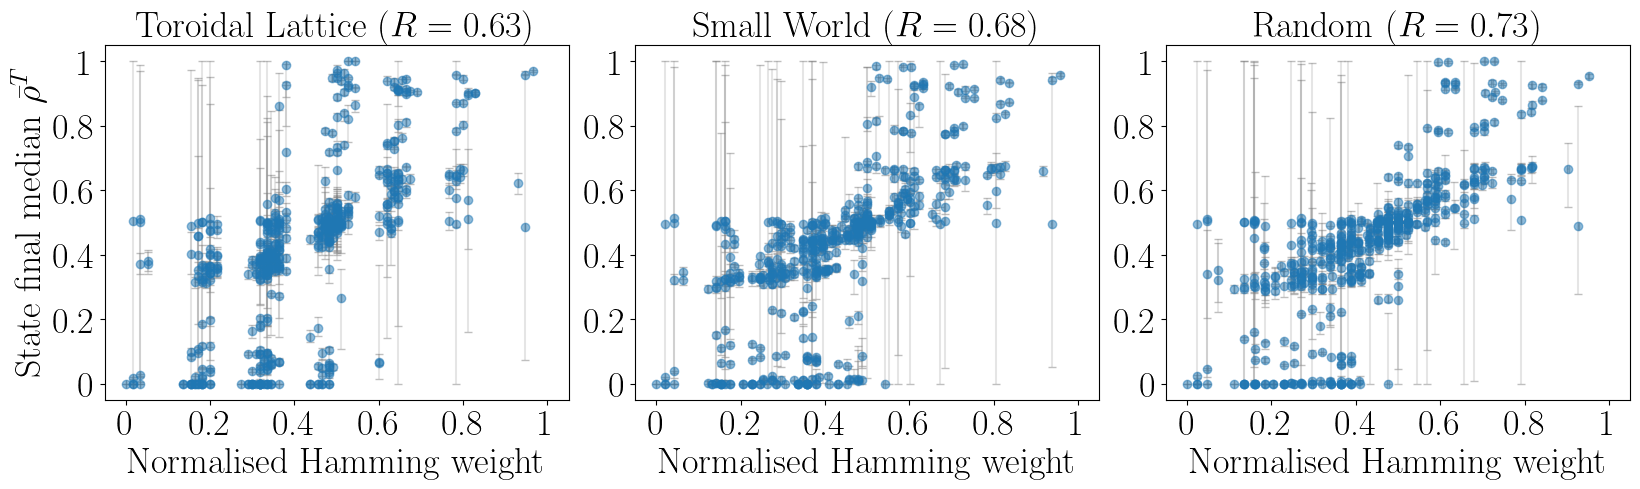

In [57]:
SAVEFIG = True

from scipy.stats import pearsonr

fig, axs = plt.subplots(1,3,figsize=(16.5,5))
fontsize=26

for idx, ax in enumerate(axs):
    # get relevant arrays
    graph_name = graph_names[idx]
    state_medians = state_medians_per_type[idx]
    state_err = np.array([state_medians - state_q1_per_type[idx], state_q3_per_type[idx] - state_medians])
    hw_medians = hw_medians_per_type[idx]
    hw_err = np.array([hw_medians - hw_q1_per_type[idx], hw_q3_per_type[idx] - hw_medians])

    # Calculate Pearson correlation
    # try:
    #     corr, r_squared = weighted_correlation_asymmetric(hw_medians, state_medians, hw_err, state_err)
    # except:
    #     print(f"weighted correlation does not work for {graph_name}.")
    corr, _ = pearsonr(hw_medians, state_medians)
    r_squared = corr**2

    # Create scatter plot with uncertainty crosses
    eb=ax.errorbar(hw_medians,
                   state_medians,
                   xerr=hw_err,
                   yerr=state_err,
                   fmt='o', ecolor='gray', capsize=3, alpha=0.5)
    for bar in eb[2]:  # eb[2] is the list of LineCollection objects for error bars
        bar.set_alpha(0.2)  # set your desired alpha for error bars here

    # make nice labels
    ax.set_xlabel('Normalised Hamming weight', fontsize=fontsize)
    # ax.set_ylabel('State final median $\\bar{\\rho}^T$', fontsize=fontsize)
    ax.set_title(f'{graph_name} ($R = {np.round(corr,2)}$)', fontsize=fontsize)

    # get identical limits for each plot
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    xticks = [0, .2, .4, .6, .8, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=fontsize)
    yticks = [0, .2, .4, .6, .8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize)

axs[0].set_ylabel('State final median $\\bar{\\rho}^T$', fontsize=fontsize)

# fig.suptitle(f"Correlation of Hamming weight to final state medians for all $528$ non-equivalent resolution-$5$ rules", fontsize=fontsize+4)
fig.tight_layout()

if SAVEFIG:
    savename = f"../figures/state-median-vs-hamming-weight_resolution{resolution}.pdf"
    plt.savefig(savename, bbox_inches='tight')

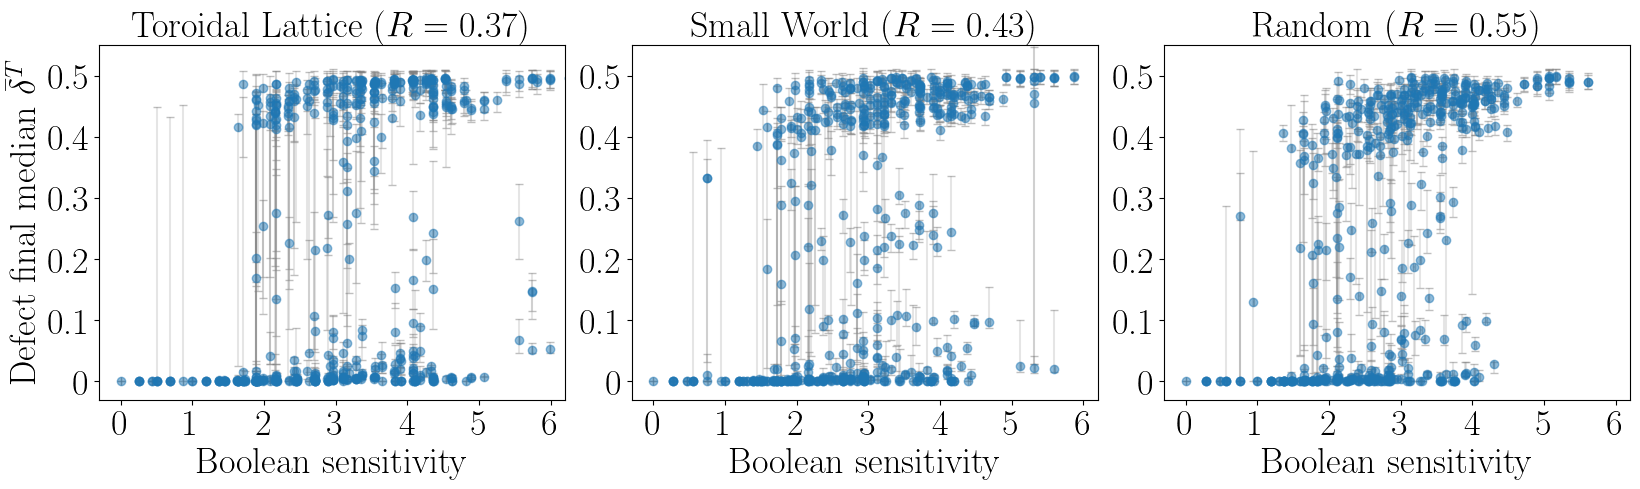

In [58]:
SAVEFIG = True

from scipy.stats import pearsonr

fig, axs = plt.subplots(1,3,figsize=(16.5,5))
fontsize=26

for idx, ax in enumerate(axs):
    # get relevant arrays
    graph_name = graph_names[idx]
    defect_medians = defect_medians_per_type[idx]
    defect_err = np.array([defect_medians - defect_q1_per_type[idx], defect_q3_per_type[idx] - defect_medians])
    bs_medians = bs_medians_per_type[idx]
    bs_err = np.array([bs_medians - bs_q1_per_type[idx], bs_q3_per_type[idx] - bs_medians])

    # Calculate Pearson correlation
    # try:
    #     corr, r_squared = weighted_correlation_asymmetric(bs_medians, defect_medians, bs_err, defect_err)
    # except:
    #     print(f"weighted correlation does not work for {graph_name}.")
    corr, _ = pearsonr(bs_medians, defect_medians)
    r_squared = corr**2

    # Create scatter plot with uncertainty crosses
    eb=ax.errorbar(bs_medians,
                   defect_medians,
                   xerr=bs_err,
                   yerr=defect_err,
                   fmt='o', ecolor='gray', capsize=3, alpha=0.5)
    for bar in eb[2]:
        bar.set_alpha(0.2)

    # make nice labels
    ax.set_xlabel('Boolean sensitivity', fontsize=fontsize)
    # ax.set_ylabel('Defect final median $\\bar{\\delta}^T$', fontsize=fontsize)
    ax.set_title(f'{graph_name} ($R = {np.round(corr,2)}$)', fontsize=fontsize)

    # get identical limits for each plot
    ax.set_xlim([-0.3, 6.2])
    ax.set_ylim([-0.03, .55])
    xticks = [0, 1, 2, 3, 4, 5, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=fontsize)
    yticks = [0, .1, .2, .3, .4, .5]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize)

axs[0].set_ylabel('Defect final median $\\bar{\\delta}^T$', fontsize=fontsize)

# fig.suptitle(f"Correlation of Boolean sensitivity to final defect medians for all $528$ non-equivalent resolution-$5$ rules", fontsize=fontsize+4)
fig.tight_layout()

if SAVEFIG:
    savename = f"../figures/defect-median-vs-boolean-sens_resolution{resolution}.pdf"
    plt.savefig(savename, bbox_inches='tight')

# Firing Squad Synchronisation Problem

<>:43: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
C:\Users\mrollier\AppData\Local\Temp\ipykernel_7620\1457555366.py:43: SyntaxWarning: invalid escape sequence '\%'
  axs[0].set_ylabel(f"Success rate (\%)", fontsize=fontsize)


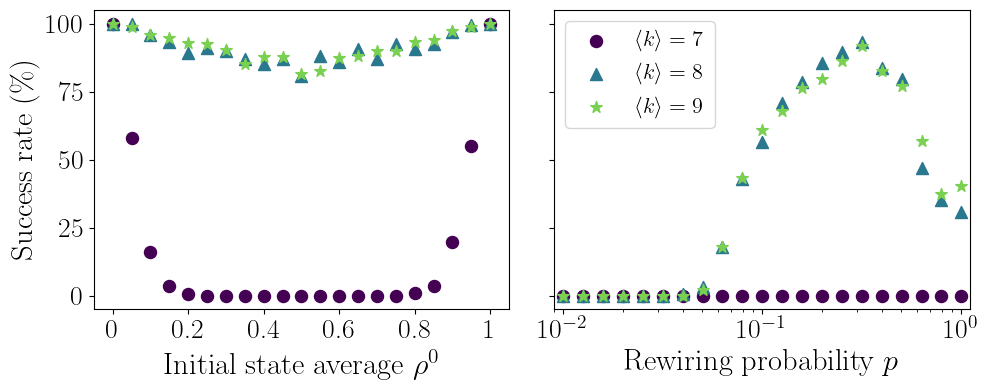

In [59]:
SAVEFIG = True

# open plot
fig, axs = plt.subplots(1,2,figsize=(10,4), sharey=True)

# choose plot props
fontsize=22
markers = ["o", "^", "*"]
markersize = 75
from matplotlib import colormaps
cmap = colormaps["viridis"]
colors = [cmap(0.), cmap(.4), cmap(.8)]

# degrees associated with the data
degrees = [7,8,9]

# load initial density data
success_rates_dens = np.load("../data/fssp/success_rates_init_dens.npy")
init_dens_array = np.linspace(0,1,21)

# QUICKFIX: something has gone wrong with the initial and last value, strangely. These should of course just be 1
success_rates_dens[:,0] = 1
success_rates_dens[:,-1] = 1

# load rewiring probs data
success_rates_prob = np.load("../data/fssp/success_rates_rewiring_probs.npy")
rewiring_prob_array = np.logspace(-2,0,21)

# plot dependency on initial density
for degree, success, marker, color in zip(degrees, success_rates_dens, markers, colors):
    axs[0].scatter(init_dens_array, success, marker=marker, s=markersize, color=color, label=f"$\\langle k\\rangle={degree}$")

# plot dependency on rewiring prob
for degree, success, marker, color in zip(degrees, success_rates_prob, markers, colors):
    axs[1].scatter(rewiring_prob_array, success, marker=marker, s=markersize, color=color, label=f"$\\langle k\\rangle={degree}$")

# choose properties of the init dens plot
axs[0].set_ylim([-0.05, 1.05])
yticks = [0, .25, .5, .75, 1]
axs[0].set_yticks(yticks)
yticklabels = ["0", "25", "50", "75", "100"]
axs[0].set_yticklabels(yticklabels, fontsize=fontsize-2)
axs[0].set_ylabel(f"Success rate (\%)", fontsize=fontsize)

xticks = [0, .2, .4, .6, .8, 1]
axs[0].set_xticks(xticks)
xticklabels = xticks
axs[0].set_xticklabels(xticklabels, fontsize=fontsize-2)
axs[0].set_xlim([-0.05, 1.05])

axs[0].set_xlabel(f"Initial state average $\\rho^0$", fontsize=fontsize)

# choose properties of the rewiring prob plot
axs[1].set_ylim([-0.05, 1.05])

xticks = [0.01, 0.1, 1]
axs[1].set_xticks(xticks)
xticklabels = ["0.01", "0.1", "1"]
axs[1].set_xticklabels(xticklabels, fontsize=fontsize-2)
axs[1].set_xlim([0.009, 1.1])

axs[1].set_xscale('log')
axs[1].set_xlabel(f"Rewiring probability $p$", fontsize=fontsize)

axs[1].legend(fontsize=fontsize-6, loc='upper left')

fig.tight_layout(w_pad=2)

if SAVEFIG:
    plt.savefig(f"../figures/fssp-succes_rate-degrees7_8_9-N900-T1800.pdf", bbox_inches='tight')